## Main code

In [1]:
! # Make sure to enable the ipycanvas/ other widgets
!jupyter labextension enable widgetsnbextension

In [8]:
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import squidpy as sq

from popari.io import save_anndata, load_anndata

from popari.simulation_framework import MultiReplicateSyntheticDataset, SyntheticDataset, SimulationParameters

from pathlib import Path

import matplotlib.pyplot as plt
import random
import seaborn as sns

In [9]:
from popari.io import save_anndata, load_anndata
from popari.components import PopariDataset
from popari._dataset_utils import _plot_all_embeddings, _plot_in_situ, _multireplicate_heatmap, _compute_empirical_correlations

In [10]:
cell_type_definitions = {
    "Excitatory L1":         [0.5, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    "Excitatory L2":         [0.5, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    "Excitatory L3":         [0.5, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    "Excitatory L4":         [0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    "Inhibitory L1":         [0, 0.5, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    "Inhibitory L2":         [0, 0.5, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    "Inhibitory L3":         [0, 0.5, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    "Inhibitory L4":         [0, 0.5, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    "Non-Neuron Ubiquitous": [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
}
progenitor_distributions = {
    "L1": {
        "Excitatory L1": 0.53,
        "Inhibitory L1": 0.2,
        "Inhibitory L2": 0.2,
        "Non-Neuron Ubiquitous": 0.07,
    },
    "L2": {
        "Excitatory L2": 0.53,
        "Inhibitory L2": 0.2,
        "Inhibitory L3": 0.2,
        "Non-Neuron Ubiquitous": 0.07,
    },
    "L3": {
        "Excitatory L3": 0.53,
        "Inhibitory L3": 0.2,
        "Inhibitory L4": 0.2,
        "Non-Neuron Ubiquitous": 0.07,
    },
    "L4": {
        "Excitatory L4": 0.53,
        "Inhibitory L3": 0.2,
        "Inhibitory L4": 0.2,
        "Non-Neuron Ubiquitous": 0.07,
    },
}

layer_distributions = {
    "L1": {
        "Excitatory L1": 0.2,
        "Excitatory L2": 0.2,
        "Inhibitory L1": 0.53,
        "Non-Neuron Ubiquitous": 0.07,
    },
    "L2": {
        "Excitatory L2": 0.2,
        "Excitatory L3": 0.2,
        "Inhibitory L2": 0.53,
        "Non-Neuron Ubiquitous": 0.07,
    },
    "L3": {
        "Excitatory L3": 0.2,
        "Excitatory L4": 0.2,
        "Inhibitory L3": 0.53,
        "Non-Neuron Ubiquitous": 0.07,
    },
    "L4": {
        "Excitatory L3": 0.2,
        "Excitatory L4": 0.2,
        "Inhibitory L4": 0.53,
        "Non-Neuron Ubiquitous": 0.07,
    },
}

metagene_variation_probabilities = [0, 0.1, 0, 0, 0.1, 0.1, 0.1, 0, 0.1, 0.1, 0.1]

shared_parameters = {
    'num_genes': 100,
    'annotation_mode': 'domain',
    'num_real_metagenes': 11,
    'num_noise_metagenes': 0,
    'sig_y_scale': 1.0,
    'sig_x_scale': 1.0,
    'real_metagene_parameter': 8.0,
    'noise_metagene_parameter': 4.0,
    'lambda_s': 1.,
    'width': 1,
    'height': 1,
    'grid_size': 15,
    'metagene_variation_probabilities': metagene_variation_probabilities,
    'cell_type_definitions': cell_type_definitions,
    'domain_key': 'domain',
}

progenitor_parameters = SimulationParameters(
    **shared_parameters,
    spatial_distributions=progenitor_distributions,
)

layer_parameters = SimulationParameters(
    **shared_parameters,
    spatial_distributions=layer_distributions,
)

num_copies = 5
duplicated_parameters = [
    {
        f"progenitor_{index}": progenitor_parameters,
        f"layer_{index}": layer_parameters,
    }
    for index in range(num_copies)
]
replicate_parameters = {replicate_name: parameters for replicate_parameters in duplicated_parameters for replicate_name, parameters in replicate_parameters.items()}

In [11]:
multireplicate_dataset = MultiReplicateSyntheticDataset(replicate_parameters, SyntheticDataset, random_state=101, verbose=0)

In [13]:
multireplicate_dataset.annotate_replicate_domain("layer_0")

Annotating replicate layer_0


Choose a domain to annotate (enter an integer):
0: L1
1: L2
2: L3
3: L4
 1


Output()

Canvas(height=600, image_data=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X\x00\x00\x02X\x08\x06\x00\x00\…

In [82]:
# layer_domains = multireplicate_dataset.datasets["layer_0"].domain_canvas.domains

for i in range(5):
   multireplicate_dataset.datasets[f"progenitor_{i}"].domain_canvas.load_domains(layer_domains)
   multireplicate_dataset.datasets[f"layer_{i}"].domain_canvas.load_domains(layer_domains) 

In [83]:
multireplicate_dataset.assign_domain_labels()

In [84]:
# # Same parameters for each replicate (for now)
# replicate_simulation_parameters = {}
# for i in range(5):
#     replicate_simulation_parameters.update({
#         f"progenitor_{i}": simulation_parameters,
#         f"layer_{i}": simulation_parameters
#     })

multireplicate_dataset.simulate_expression()

Simulating expression for progenitor_0.
Simulating domain-annotated expression...
Simulating expression for layer_0.
Simulating domain-annotated expression...
Simulating expression for progenitor_1.
Simulating domain-annotated expression...
Simulating expression for layer_1.
Simulating domain-annotated expression...
Simulating expression for progenitor_2.
Simulating domain-annotated expression...
Simulating expression for layer_2.
Simulating domain-annotated expression...
Simulating expression for progenitor_3.
Simulating domain-annotated expression...
Simulating expression for layer_3.
Simulating domain-annotated expression...
Simulating expression for progenitor_4.
Simulating domain-annotated expression...
Simulating expression for layer_4.
Simulating domain-annotated expression...


In [85]:
multireplicate_dataset.calculate_neighbors(coord_type="grid", n_neighs=4, delaunay=False)

In [86]:
def sample_graph_iid(adjacency_list, indices_remaining, sample_size):                              
    valid_indices = []                                                                             
    excluded_indices = set()                                                                       
    effective_batch_size = min(sample_size, len(indices_remaining))                                
    candidate_indices = np.random.choice(list(indices_remaining),                                  
        size=effective_batch_size,                                                                 
        replace=False,                                                                             
    )                                                                                              
    for index in candidate_indices:                                                                
        if index not in excluded_indices:                                                                                                                                                                                                                                       
            valid_indices.append(index)                                                            
            excluded_indices |= set(adjacency_list[index])                                         
                                                                                                   
    return valid_indices   

def adjacency_matrix_to_list(adjacency_matrix):
    """
    """
    adjacency_matrix = adjacency_matrix.tocoo()                                

    num_cells, _ = adjacency_matrix.shape                                                      
    adjacency_list = [[] for _ in range(num_cells)]                                                                                                                                                                                                                         
    for x, y in zip(*adjacency_matrix.nonzero()):                                              
        adjacency_list[x].append(y)                                                            

    return adjacency_list   

In [87]:
# # Actually spatial downsampling
# # Only handles sparsity up to a certain level, due to method of choosing independent set

# rng = np.random.default_rng(seed=0)
# sparsity = 0.08
# for name, dataset in multireplicate_dataset.datasets.items():
#     num_cells, num_genes = dataset.shape
#     num_dropout_cells = np.rint(sparsity * num_cells).astype(int)
    
#     adjacency_list = adjacency_matrix_to_list(dataset.obsp["adjacency_matrix"])
    
#     for gene_index in range(num_genes):
#         independent_set = sample_graph_iid(adjacency_list, set(range(num_cells)), num_cells)
    
#         dropout_cells = independent_set[:num_dropout_cells]
#         dataset.X[dropout_cells, gene_index] = 0

In [88]:
(replicate_names, datasets) = zip(*multireplicate_dataset.datasets.items())

/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 100 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


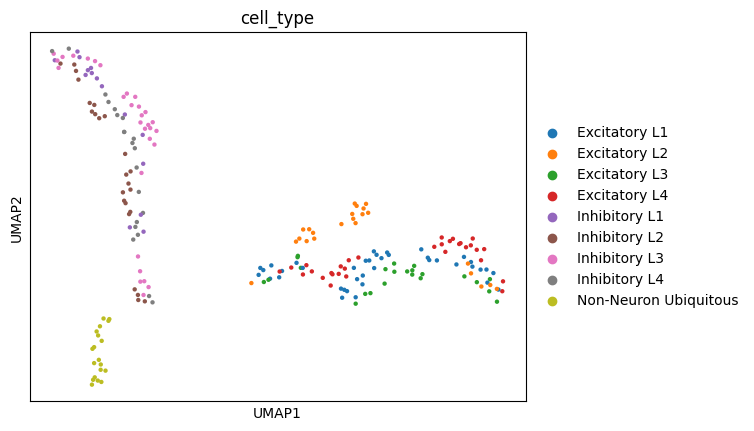

In [89]:
fig, ax = plt.subplots()
sc.pp.neighbors(datasets[0])
sc.tl.umap(datasets[0])
sc.pl.umap(datasets[0], color="cell_type", ax=ax, size=40)

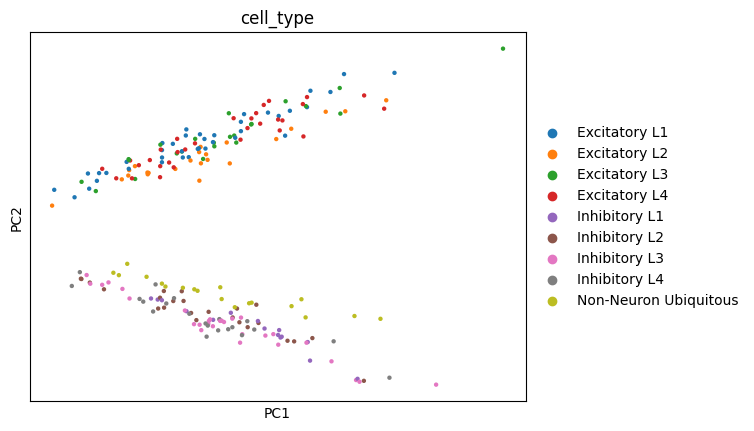

In [90]:
fig, ax = plt.subplots()
sc.tl.pca(datasets[0])
sc.pl.pca(datasets[0], color="cell_type", ax=ax, size=40)

/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 100 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


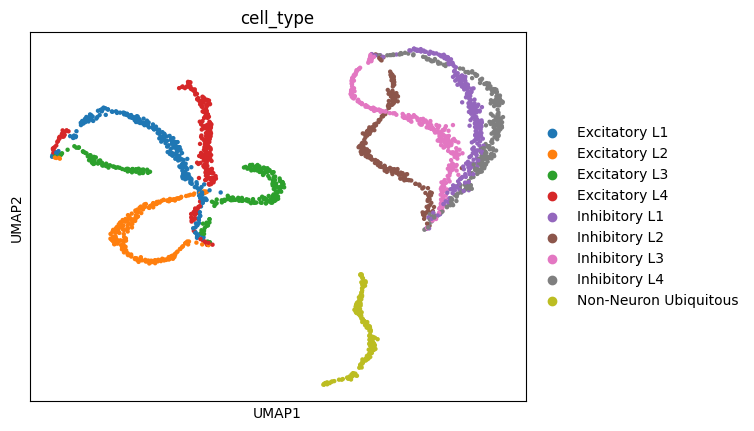

In [91]:
replicate_names, dataset_copies = zip(*multireplicate_dataset.datasets.items())
merged_dataset = ad.concat(dataset_copies, label="batch", keys=replicate_names, merge="unique", uns_merge="unique", pairwise=True)                                                                                                                                        
fig, ax = plt.subplots()
sc.pp.neighbors(merged_dataset)
sc.tl.umap(merged_dataset)
sc.pl.umap(merged_dataset, color="cell_type", ax=ax, size=40)

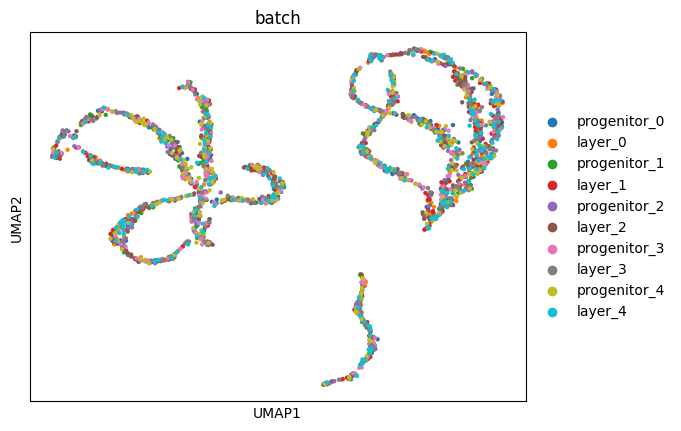

In [92]:
fig, ax = plt.subplots()
sc.pl.umap(merged_dataset, color="batch", ax=ax, size=40)

In [93]:
save_directory = Path("../../data/synthetic_cortex/joint_improvement_multireplicate/")
save_directory.mkdir(exist_ok=True)
filepath = save_directory/ "processed_dataset.h5ad"
result = save_anndata(filepath, datasets)

/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [94]:
from popari._dataset_utils import _plot_in_situ

/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/work/magroup/shahula/bin/miniconda3

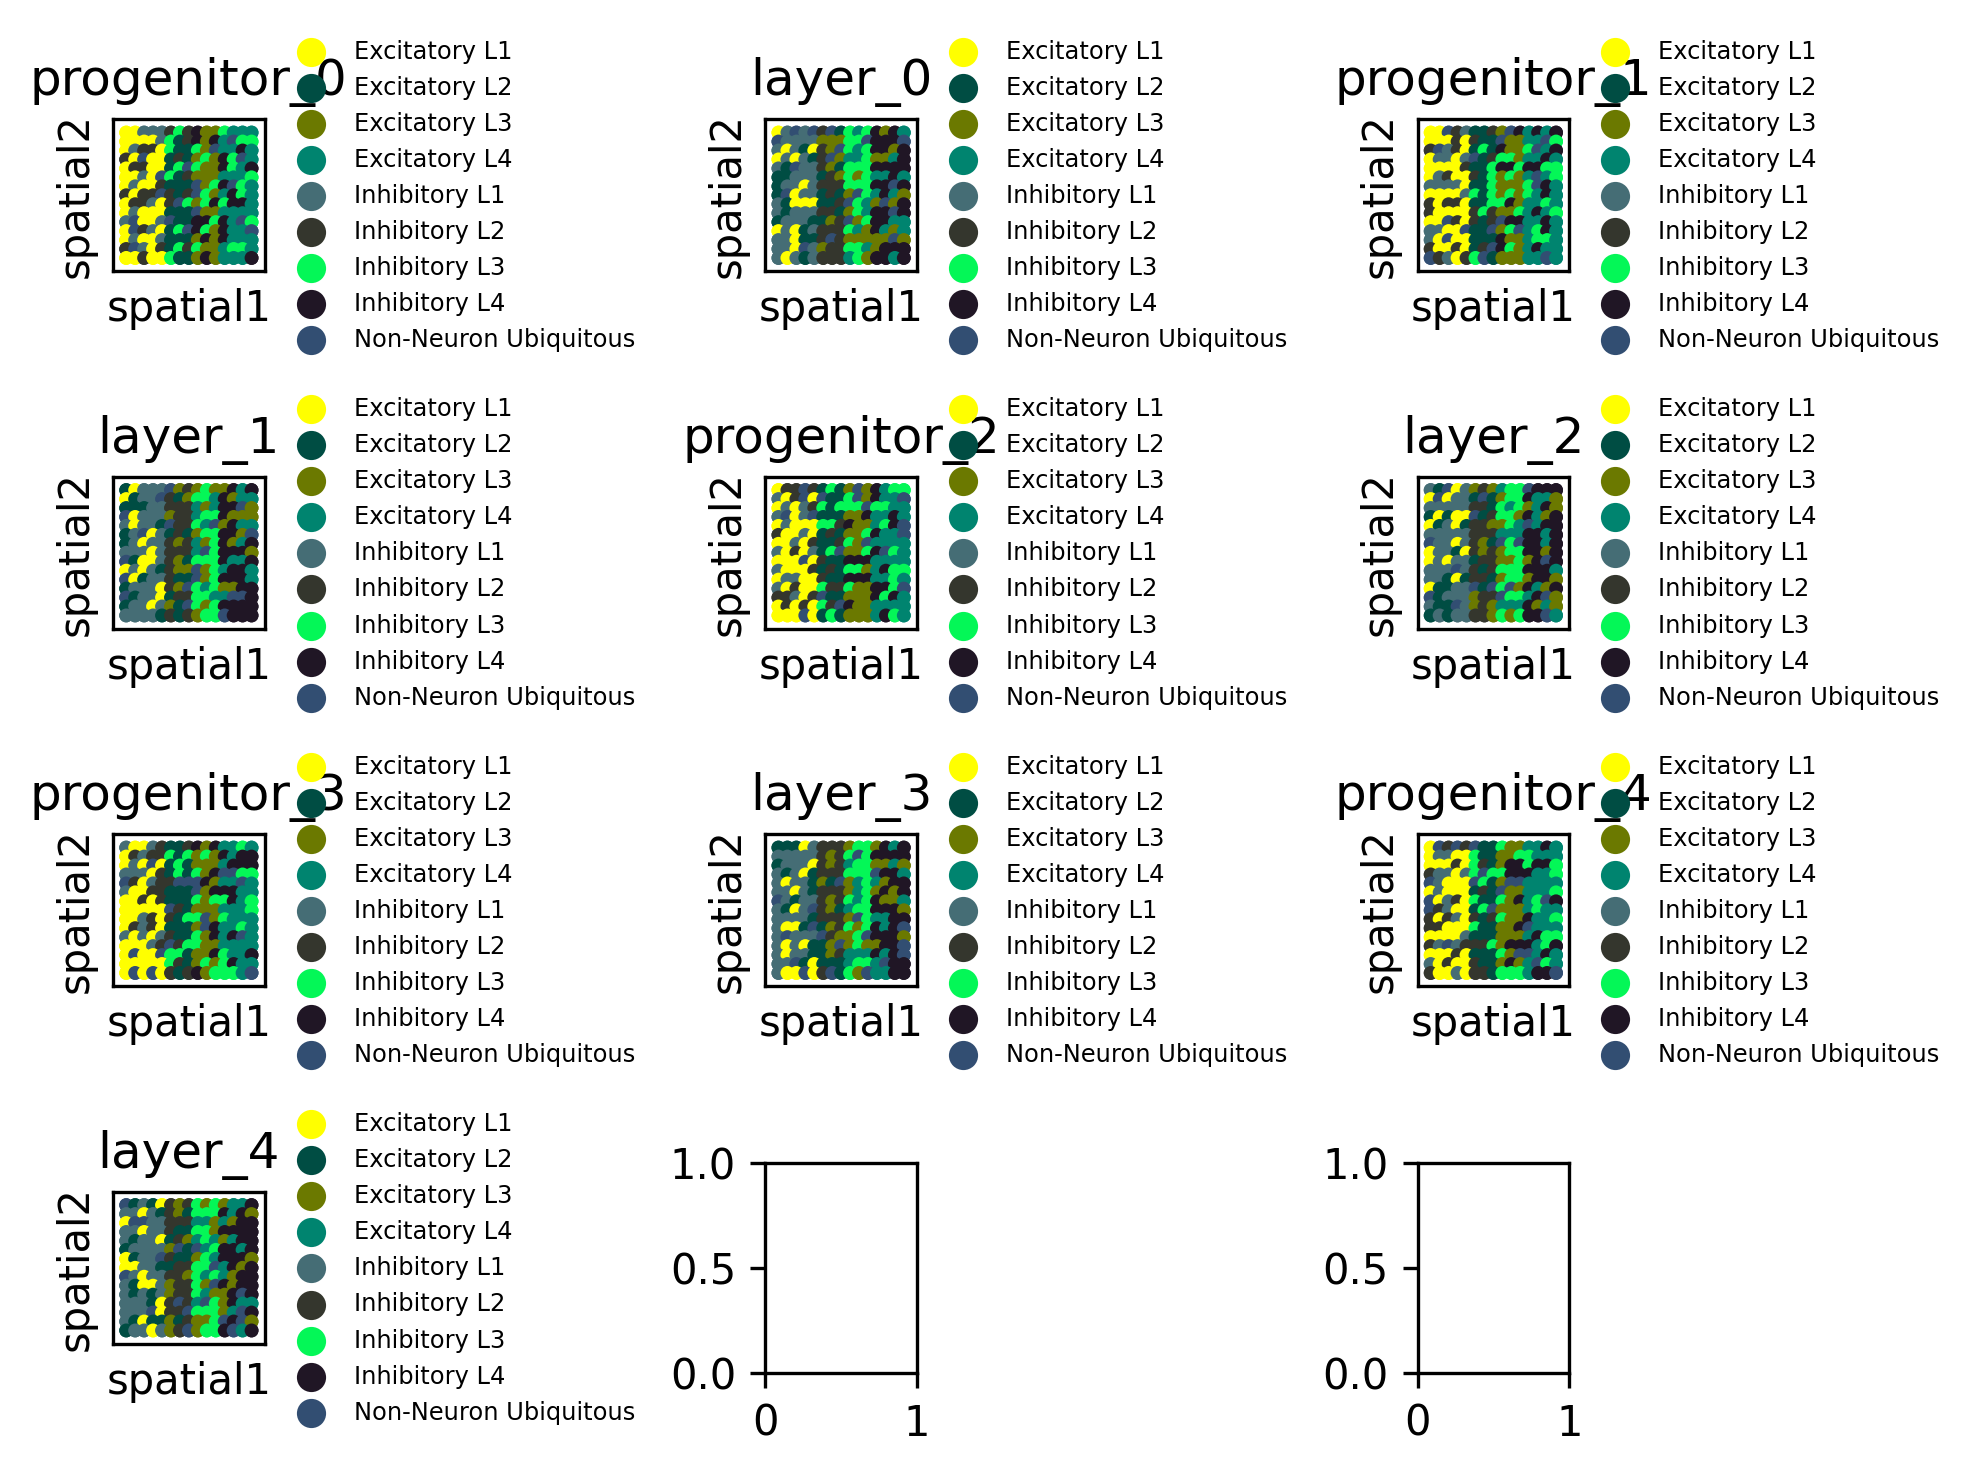

In [95]:
_ = _plot_in_situ(datasets, color="cell_type", size=1)

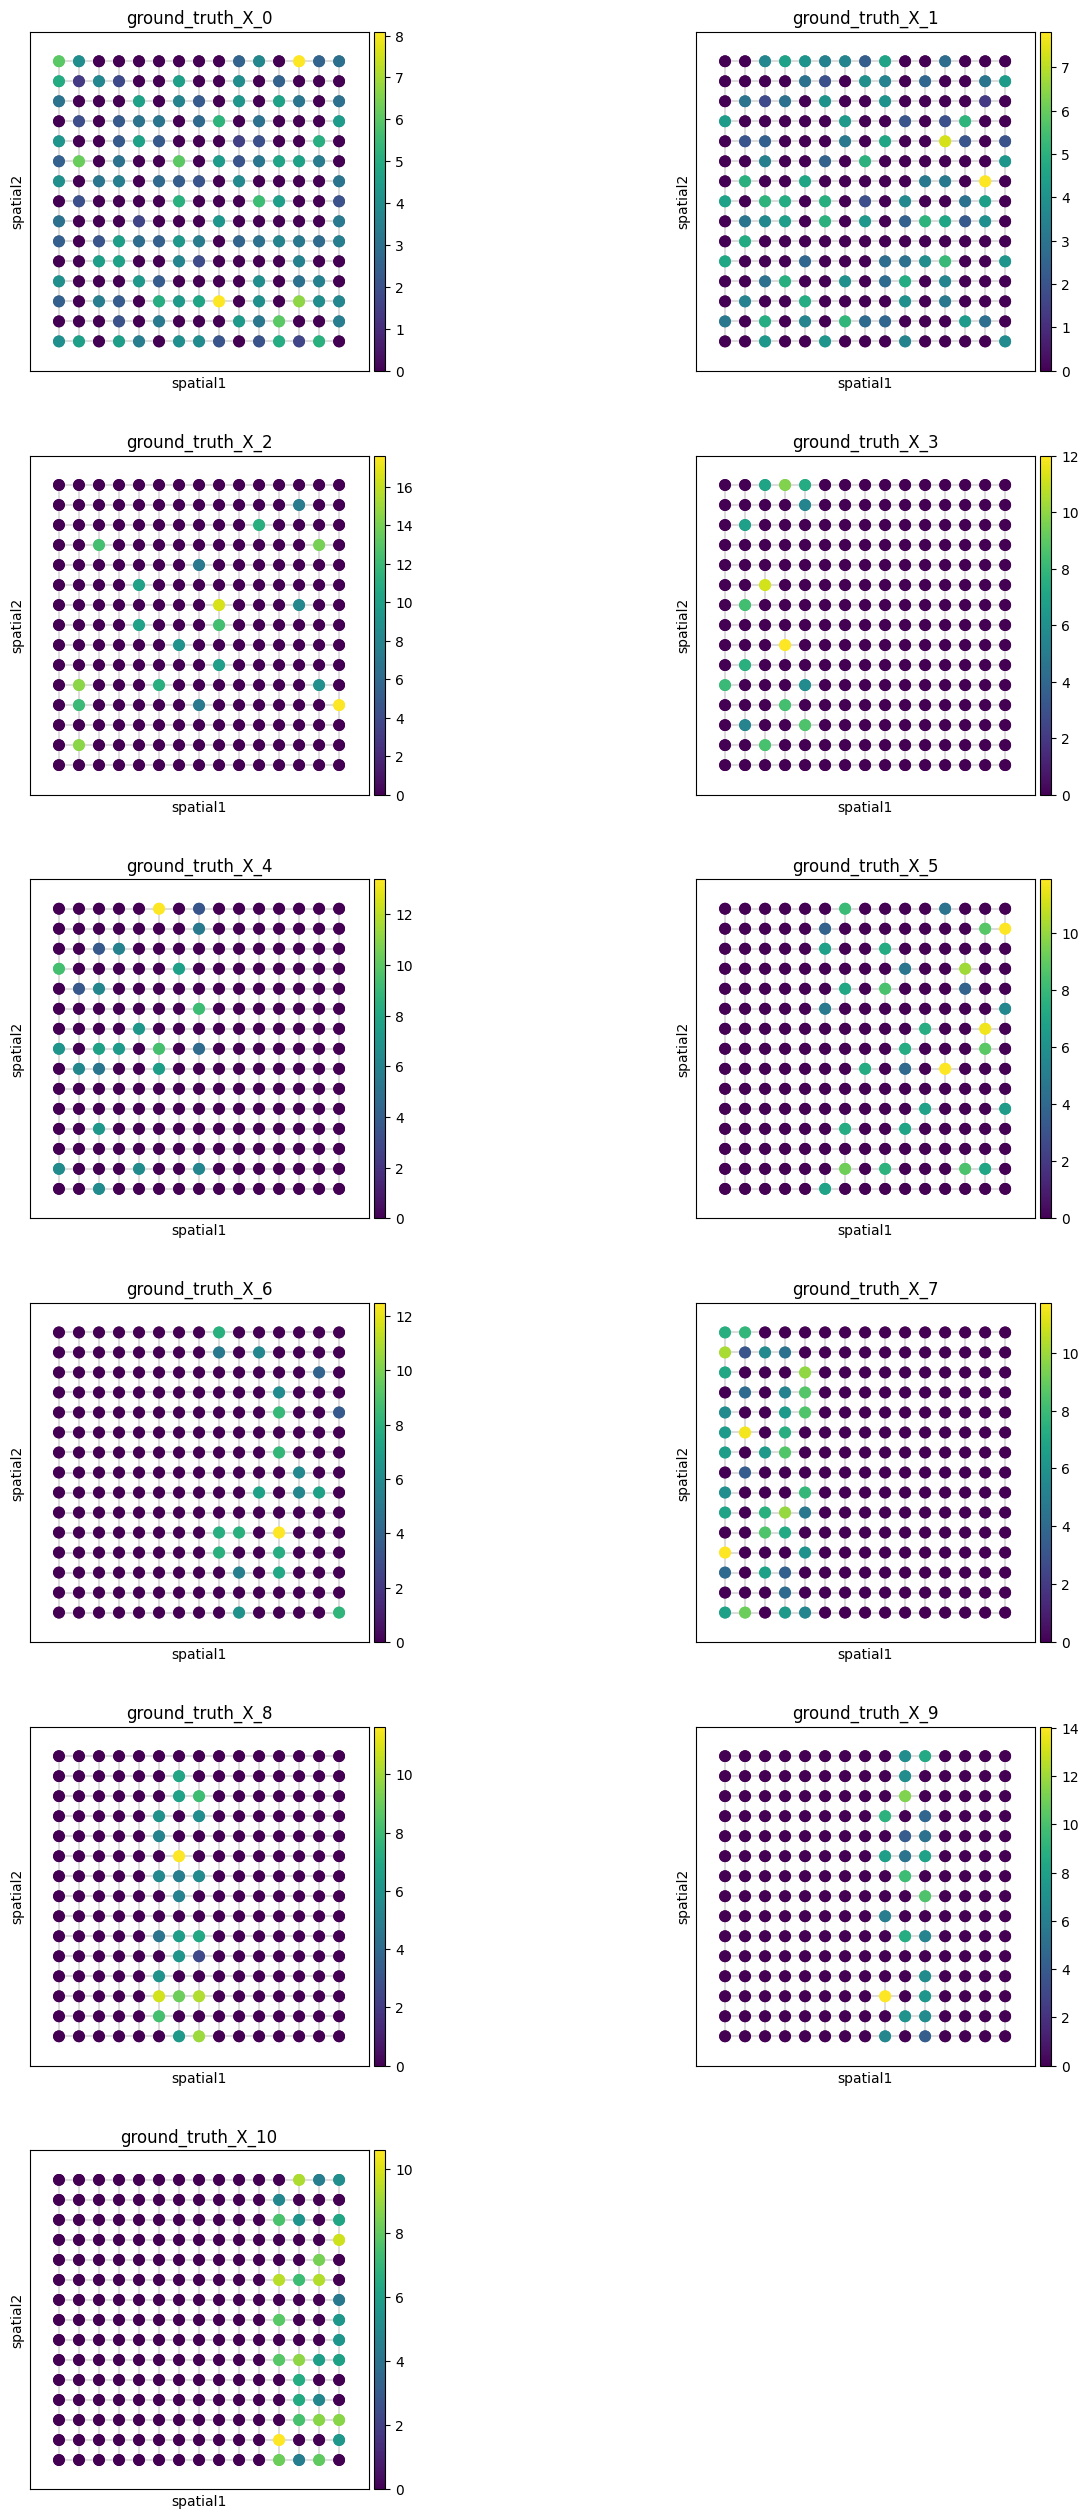

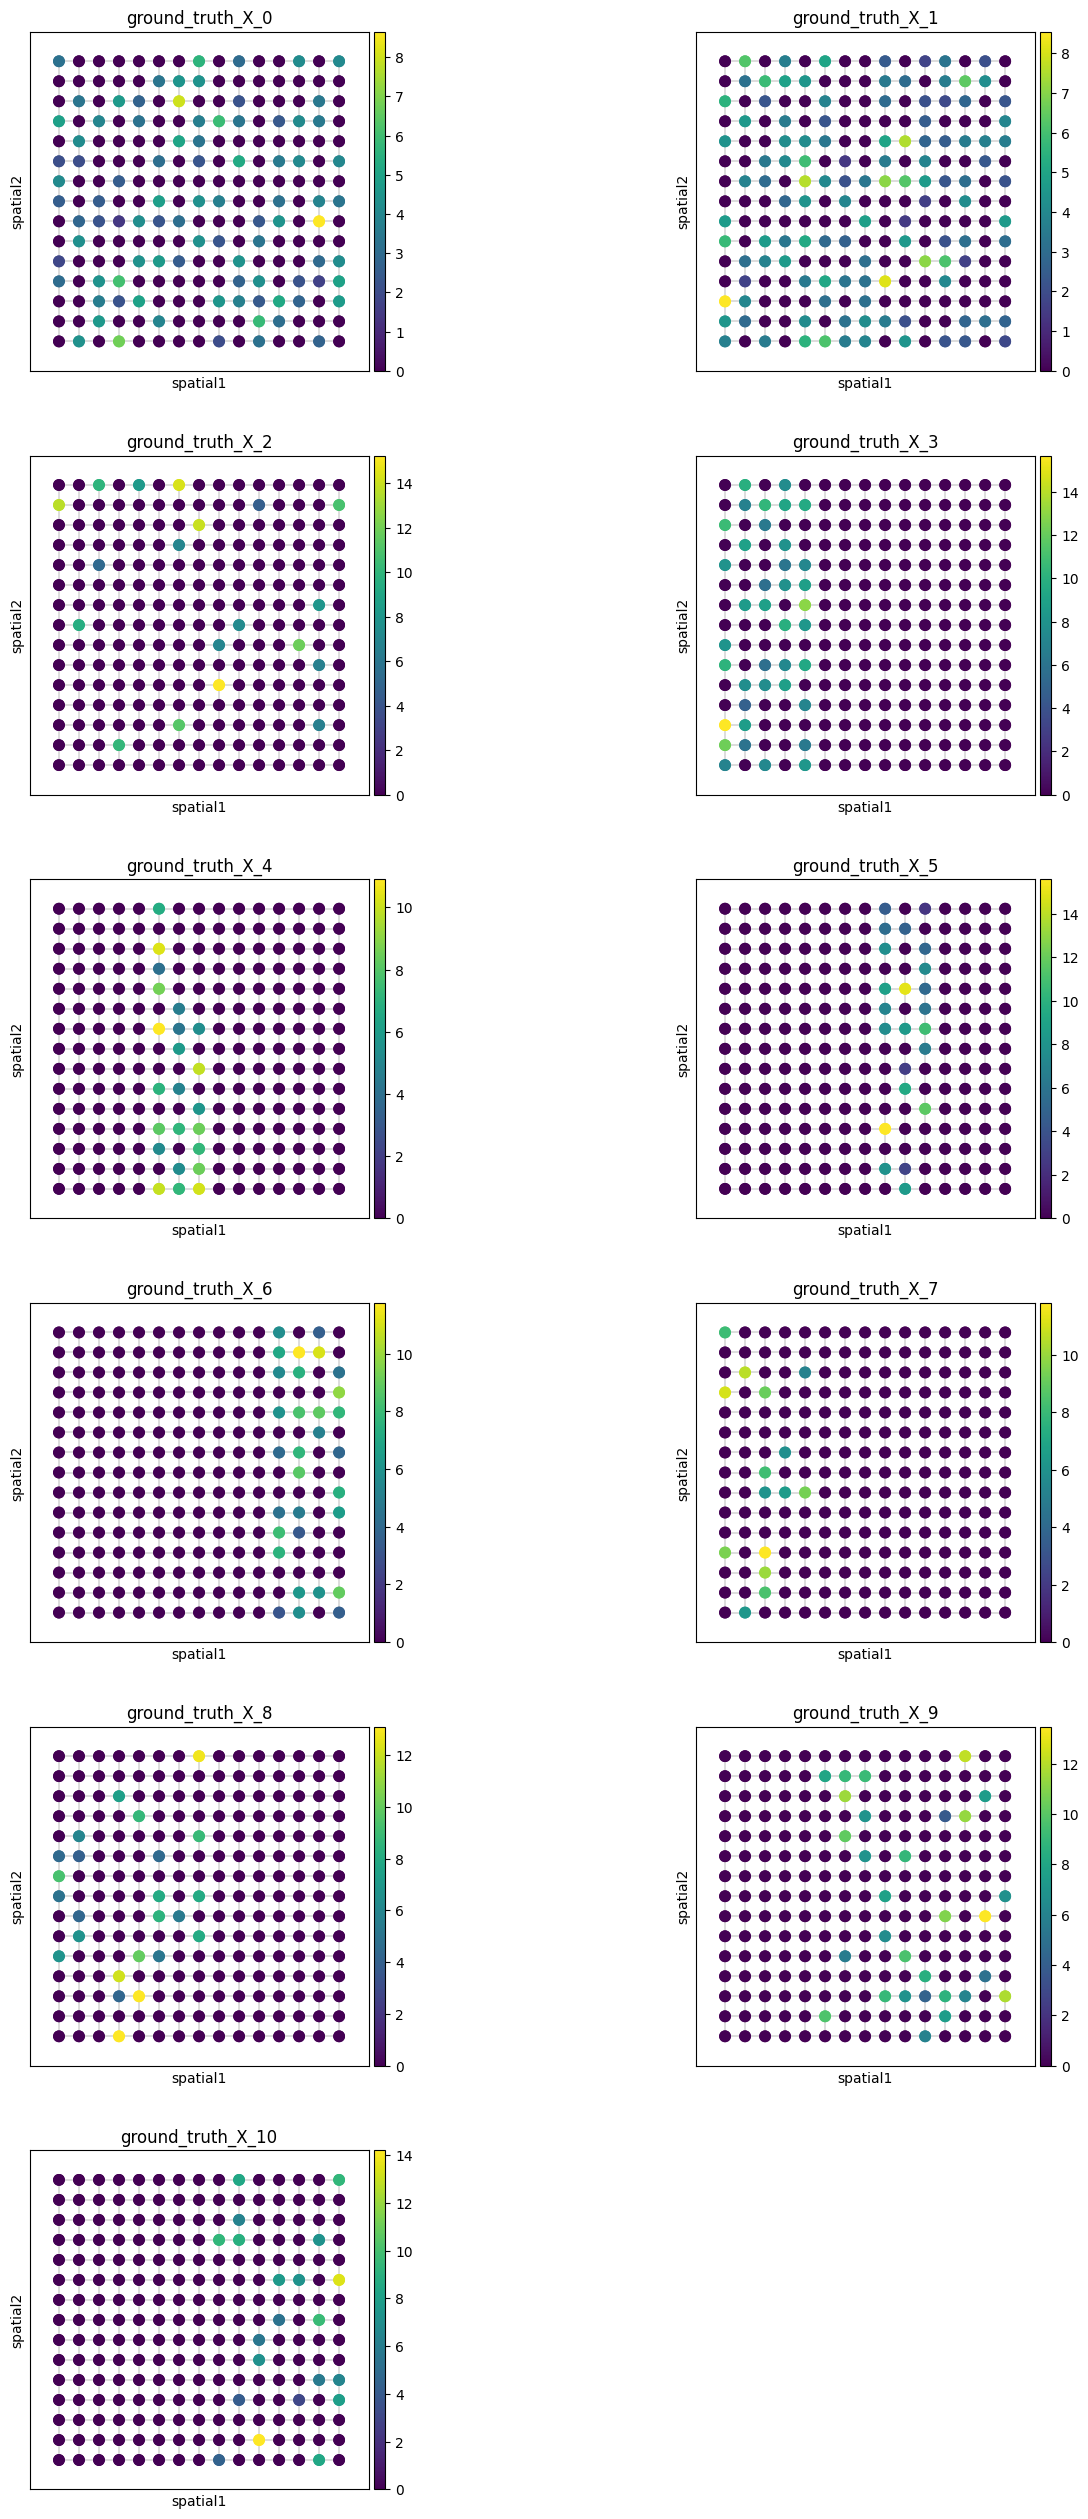

In [96]:
_ = _plot_all_embeddings(datasets[0], embedding_key="ground_truth_X", size=100)
_ = _plot_all_embeddings(datasets[1], embedding_key="ground_truth_X", size=100)

In [97]:
# _ = _plot_all_embeddings(popari.datasets[1], embedding_key="ground_truth_X", size=20)

In [98]:
_compute_empirical_correlations(datasets, feature="ground_truth_X", output="ground_truth_correlation", scaling=10)   

(AnnData object with n_obs × n_vars = 225 × 100
     obs: 'domain', 'cell_type', 'cell_type_encoded', 'adjacency_list'
     uns: 'domain_names', 'simulation_parameters', 'cell_type_definitions', 'domain_landmarks', 'ground_truth_M', 'spatial_neighbors', 'pca', 'neighbors', 'umap', 'cell_type_colors', 'adjacency_matrix', 'dataset_name', 'ground_truth_correlation'
     obsm: 'spatial', 'ground_truth_X', 'X_pca', 'X_umap'
     varm: 'PCs'
     obsp: 'spatial_connectivities', 'spatial_distances', 'adjacency_matrix', 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 225 × 100
     obs: 'domain', 'cell_type', 'cell_type_encoded', 'adjacency_list'
     uns: 'domain_names', 'simulation_parameters', 'cell_type_definitions', 'domain_landmarks', 'ground_truth_M', 'spatial_neighbors', 'adjacency_matrix', 'dataset_name', 'cell_type_colors', 'ground_truth_correlation'
     obsm: 'spatial', 'ground_truth_X'
     obsp: 'spatial_connectivities', 'spatial_distances', 'adjacency_matrix

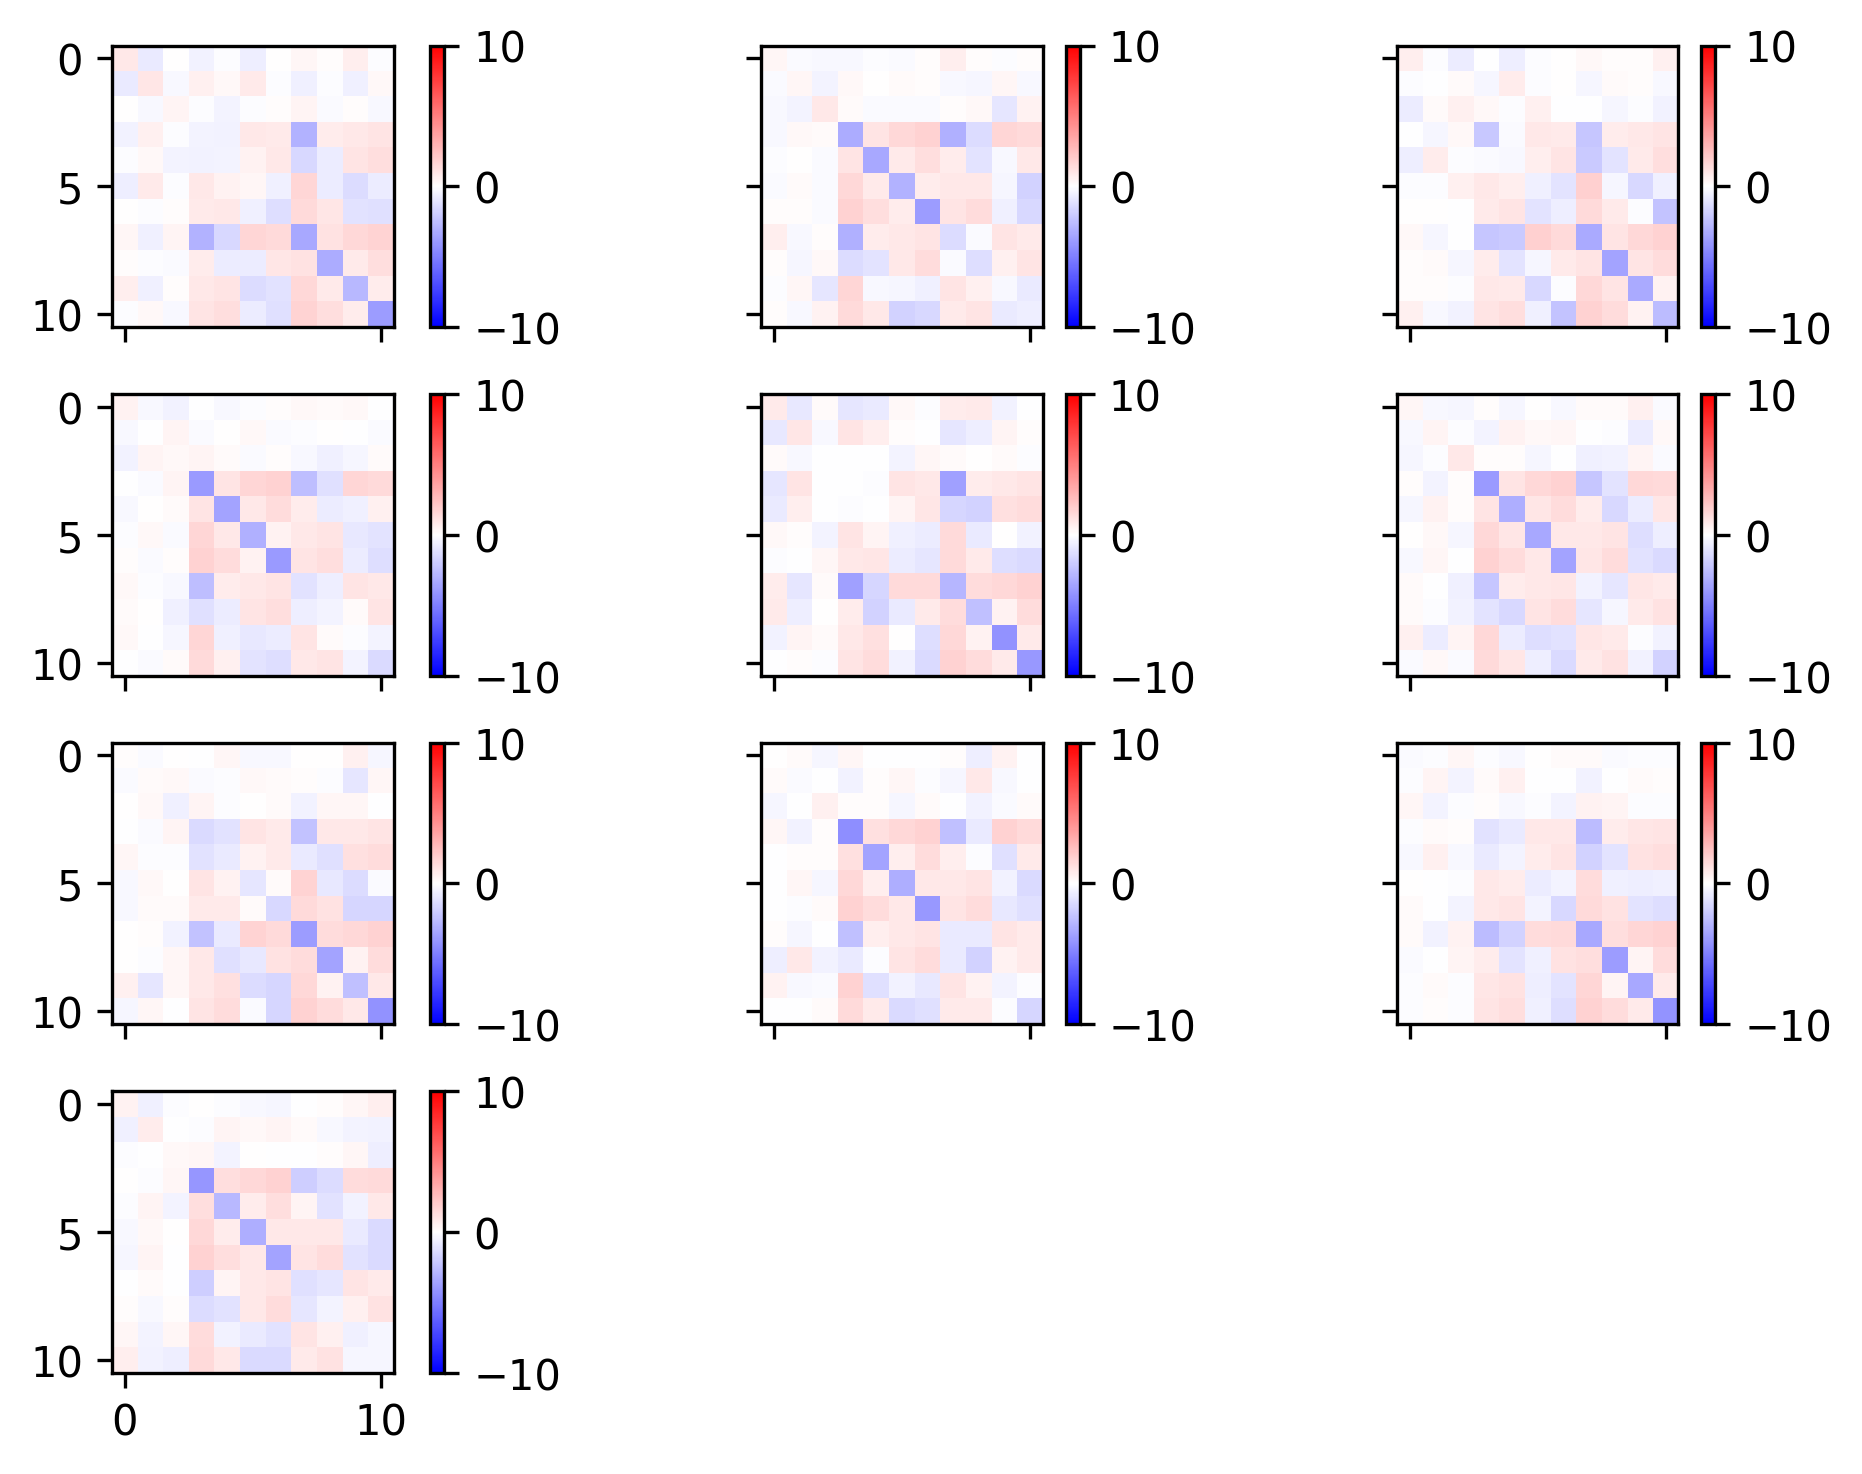

In [99]:
from popari._dataset_utils import _multireplicate_heatmap
_ = _multireplicate_heatmap(datasets, uns="ground_truth_correlation", cmap="bwr", vmin=-10, vmax=10)

In [31]:
import torch
from popari.model import Popari
from popari import pl, tl

from matplotlib import pyplot as plt

from popari._dataset_utils import _plot_all_embeddings

In [32]:
dataset_names = [dataset_name for dataset_name, _ in multireplicate_dataset.datasets.items()]

In [33]:
lambda_Sigma_x_inv=1e-4
lambda_Sigma_bar=1e-4
torch_context={
    "dtype": torch.float64,
    "device": "cuda:0"
}
dataset_path = "../../data/synthetic_cortex/joint_improvement_multireplicate/processed_dataset.h5ad"
K = 11
seed = 42

nmf_preiterations = 10
num_iterations = 200

groups = {dataset_name: [dataset_name] for dataset_name in dataset_names}

In [34]:
# Initialize                                                                    
nmf = Popari(                                                                   
    K=K,                                                                        
    dataset_path=dataset_path,                                                                     
    lambda_Sigma_x_inv=lambda_Sigma_x_inv,                                      
    initial_context=torch_context,                                              
    torch_context=torch_context,
    initialization_method="leiden",
    verbose=1,               
    hierarchical_levels=1,  
    random_state=seed                                                           
)

popari = Popari(                                                              
    K=K,                                                                        
    dataset_path=dataset_path,                                                                        
    lambda_Sigma_x_inv=lambda_Sigma_x_inv,
    spatial_affinity_mode="differential lookup",
    initial_context=torch_context,                                              
    torch_context=torch_context,
    initialization_method="leiden",
    hierarchical_levels=1,
    verbose=1,                                                                  
    random_state=seed                                                           
)                     


spicemix = Popari(                                                              
    K=K,                                                                        
    dataset_path=dataset_path,                                                                        
    lambda_Sigma_x_inv=lambda_Sigma_x_inv,                                      
    initial_context=torch_context,                                              
    torch_context=torch_context,
    initialization_method="leiden",
    hierarchical_levels=1,
    verbose=1,                                                                  
    random_state=seed                                                           
)

disjoint_spicemix = Popari(                                                              
    K=K,                                                                        
    dataset_path=dataset_path,                                                                        
    lambda_Sigma_x_inv=lambda_Sigma_x_inv,                                      
    initial_context=torch_context,                                              
    torch_context=torch_context,
    initialization_method="leiden",
    hierarchical_levels=1,
    metagene_groups=groups,
    spatial_affinity_groups=groups,
    verbose=1,                                                                  
    random_state=seed                                                           
)    



models = (nmf, spicemix, disjoint_spicemix, popari)                                 
# models = (nmf, popari_hierarchical)   

/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.8/site-packages/popari/util.py:499: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  i = torch.LongTensor(indices)
/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


[2023/12/04 20:18:47]	 Initializing MetageneState
[2023/12/04 20:18:47]	 Initializing SpatialAffinityState
[2023/12/04 20:18:47]	 Initializing EmbeddingOptimizer
[2023/12/04 20:18:47]	 Initializing EmbeddingState
[2023/12/04 20:18:47]	 Initializing metagenes and hidden states using leiden method
Current number of clusters: 28
Resolution: 1.0
Current number of clusters: 15
Resolution: 0.31622776601683794
Current number of clusters: 12
Resolution: 0.1778279410038923
Current number of clusters: 11
Resolution: 0.1333521432163324
[2023/12/04 20:18:50]	 Initializing Sigma_x_inv with empirical correlations


/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


[2023/12/04 20:18:50]	 Initializing MetageneState
[2023/12/04 20:18:50]	 Initializing SpatialAffinityState
[2023/12/04 20:18:50]	 Initializing EmbeddingOptimizer
[2023/12/04 20:18:50]	 Initializing EmbeddingState
[2023/12/04 20:18:50]	 Initializing metagenes and hidden states using leiden method
Current number of clusters: 28
Resolution: 1.0
Current number of clusters: 15
Resolution: 0.31622776601683794
Current number of clusters: 12
Resolution: 0.1778279410038923
Current number of clusters: 11
Resolution: 0.1333521432163324
[2023/12/04 20:18:52]	 Initializing Sigma_x_inv with empirical correlations


/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


[2023/12/04 20:18:53]	 Initializing MetageneState
[2023/12/04 20:18:53]	 Initializing SpatialAffinityState
[2023/12/04 20:18:53]	 Initializing EmbeddingOptimizer
[2023/12/04 20:18:53]	 Initializing EmbeddingState
[2023/12/04 20:18:53]	 Initializing metagenes and hidden states using leiden method
Current number of clusters: 28
Resolution: 1.0
Current number of clusters: 15
Resolution: 0.31622776601683794
Current number of clusters: 12
Resolution: 0.1778279410038923
Current number of clusters: 11
Resolution: 0.1333521432163324
[2023/12/04 20:18:54]	 Initializing Sigma_x_inv with empirical correlations


/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


[2023/12/04 20:18:55]	 Initializing MetageneState
[2023/12/04 20:18:55]	 Initializing SpatialAffinityState
[2023/12/04 20:18:55]	 Initializing EmbeddingOptimizer
[2023/12/04 20:18:55]	 Initializing EmbeddingState
[2023/12/04 20:18:55]	 Initializing metagenes and hidden states using leiden method
Current number of clusters: 28
Resolution: 1.0
Current number of clusters: 15
Resolution: 0.31622776601683794
Current number of clusters: 12
Resolution: 0.1778279410038923
Current number of clusters: 11
Resolution: 0.1333521432163324
[2023/12/04 20:18:57]	 Initializing Sigma_x_inv with empirical correlations


In [35]:
for iteration in range(nmf_preiterations): #NMF Initialization                  
    print(f"---- Iteration {iteration} ----")                                   
    for model in models:                                                        
        model.estimate_parameters(update_spatial_affinities=False)              
        model.estimate_weights(use_neighbors=False)                             

---- Iteration 0 ----
[2023/12/04 20:18:57]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:18:57]	 Updating sigma_yx
[2023/12/04 20:18:58]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:19:02]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:19:02]	 Updating sigma_yx
[2023/12/04 20:19:02]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:19:07]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:19:07]	 Updating sigma_yx
[2023/12/04 20:19:07]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:19:12]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:19:12]	 Updating sigma_yx
[2023/12/04 20:19:12]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 1 ----
[2023/12/04 20:19:17]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:19:17]	 Updating sigma_yx
[2023/12/04 20:19:17]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:19:21]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:19:21]	 Updating sigma_yx
[2023/12/04 20:19:21]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:19:25]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:19:26]	 Updating sigma_yx
[2023/12/04 20:19:26]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:19:30]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:19:30]	 Updating sigma_yx
[2023/12/04 20:19:31]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 2 ----
[2023/12/04 20:19:35]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:19:35]	 Updating sigma_yx
[2023/12/04 20:19:35]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:19:39]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:19:39]	 Updating sigma_yx
[2023/12/04 20:19:39]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:19:43]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:19:43]	 Updating sigma_yx
[2023/12/04 20:19:43]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:19:47]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:19:47]	 Updating sigma_yx
[2023/12/04 20:19:48]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 3 ----
[2023/12/04 20:19:51]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:19:51]	 Updating sigma_yx
[2023/12/04 20:19:52]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:19:55]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:19:55]	 Updating sigma_yx
[2023/12/04 20:19:56]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:19:59]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:20:00]	 Updating sigma_yx
[2023/12/04 20:20:00]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:20:03]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:20:03]	 Updating sigma_yx
[2023/12/04 20:20:04]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 4 ----
[2023/12/04 20:20:08]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:20:08]	 Updating sigma_yx
[2023/12/04 20:20:09]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:20:13]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:20:13]	 Updating sigma_yx
[2023/12/04 20:20:13]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:20:17]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:20:17]	 Updating sigma_yx
[2023/12/04 20:20:17]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:20:22]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:20:22]	 Updating sigma_yx
[2023/12/04 20:20:22]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 5 ----
[2023/12/04 20:20:26]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:20:26]	 Updating sigma_yx
[2023/12/04 20:20:26]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:20:30]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:20:30]	 Updating sigma_yx
[2023/12/04 20:20:31]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:20:35]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:20:35]	 Updating sigma_yx
[2023/12/04 20:20:35]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:20:40]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:20:40]	 Updating sigma_yx
[2023/12/04 20:20:40]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 6 ----
[2023/12/04 20:20:44]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:20:44]	 Updating sigma_yx
[2023/12/04 20:20:45]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:20:49]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:20:49]	 Updating sigma_yx
[2023/12/04 20:20:49]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:20:54]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:20:54]	 Updating sigma_yx
[2023/12/04 20:20:55]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:20:59]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:20:59]	 Updating sigma_yx
[2023/12/04 20:21:00]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 7 ----
[2023/12/04 20:21:04]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:21:04]	 Updating sigma_yx
[2023/12/04 20:21:04]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:21:09]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:21:09]	 Updating sigma_yx
[2023/12/04 20:21:09]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:21:14]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:21:14]	 Updating sigma_yx
[2023/12/04 20:21:15]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:21:19]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:21:20]	 Updating sigma_yx
[2023/12/04 20:21:20]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 8 ----
[2023/12/04 20:21:25]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:21:25]	 Updating sigma_yx
[2023/12/04 20:21:25]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:21:30]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:21:30]	 Updating sigma_yx
[2023/12/04 20:21:30]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:21:35]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:21:35]	 Updating sigma_yx
[2023/12/04 20:21:36]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:21:41]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:21:41]	 Updating sigma_yx
[2023/12/04 20:21:41]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 9 ----
[2023/12/04 20:21:46]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:21:46]	 Updating sigma_yx
[2023/12/04 20:21:46]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:21:51]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:21:51]	 Updating sigma_yx
[2023/12/04 20:21:51]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:21:56]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:21:57]	 Updating sigma_yx
[2023/12/04 20:21:57]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:22:02]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:22:02]	 Updating sigma_yx
[2023/12/04 20:22:02]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [36]:
for model in models:                                                            
    model.parameter_optimizer.reinitialize_spatial_affinities()                 
    model.synchronize_datasets()                                                

In [37]:
for iteration in range(num_iterations): #Finish training NMF                    
    print(f"---- Iteration {iteration} ----")                                   
    nmf.estimate_parameters(update_spatial_affinities=False)                    
    nmf.estimate_weights(use_neighbors=False)                                   

---- Iteration 0 ----
[2023/12/04 20:25:41]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:25:41]	 Updating sigma_yx
[2023/12/04 20:25:41]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 1 ----
[2023/12/04 20:25:46]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:25:46]	 Updating sigma_yx
[2023/12/04 20:25:46]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 2 ----
[2023/12/04 20:25:51]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:25:51]	 Updating sigma_yx
[2023/12/04 20:25:52]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 3 ----
[2023/12/04 20:25:57]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:25:57]	 Updating sigma_yx
[2023/12/04 20:25:57]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 4 ----
[2023/12/04 20:26:02]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:26:02]	 Updating sigma_yx
[2023/12/04 20:26:02]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 5 ----
[2023/12/04 20:26:07]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:26:08]	 Updating sigma_yx
[2023/12/04 20:26:08]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 6 ----
[2023/12/04 20:26:13]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:26:13]	 Updating sigma_yx
[2023/12/04 20:26:13]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 7 ----
[2023/12/04 20:26:18]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:26:18]	 Updating sigma_yx
[2023/12/04 20:26:19]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 8 ----
[2023/12/04 20:26:24]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:26:24]	 Updating sigma_yx
[2023/12/04 20:26:24]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 9 ----
[2023/12/04 20:26:29]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:26:29]	 Updating sigma_yx
[2023/12/04 20:26:29]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 10 ----
[2023/12/04 20:26:34]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:26:34]	 Updating sigma_yx
[2023/12/04 20:26:35]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 11 ----
[2023/12/04 20:26:40]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:26:40]	 Updating sigma_yx
[2023/12/04 20:26:40]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 12 ----
[2023/12/04 20:26:45]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:26:45]	 Updating sigma_yx
[2023/12/04 20:26:46]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 13 ----
[2023/12/04 20:26:51]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:26:51]	 Updating sigma_yx
[2023/12/04 20:26:51]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 14 ----
[2023/12/04 20:26:56]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:26:56]	 Updating sigma_yx
[2023/12/04 20:26:57]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 15 ----
[2023/12/04 20:27:02]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:27:02]	 Updating sigma_yx
[2023/12/04 20:27:02]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 16 ----
[2023/12/04 20:27:08]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:27:08]	 Updating sigma_yx
[2023/12/04 20:27:08]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 17 ----
[2023/12/04 20:27:13]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:27:13]	 Updating sigma_yx
[2023/12/04 20:27:14]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 18 ----
[2023/12/04 20:27:19]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:27:19]	 Updating sigma_yx
[2023/12/04 20:27:19]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 19 ----
[2023/12/04 20:27:24]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:27:24]	 Updating sigma_yx
[2023/12/04 20:27:25]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 20 ----
[2023/12/04 20:27:30]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:27:30]	 Updating sigma_yx
[2023/12/04 20:27:30]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 21 ----
[2023/12/04 20:27:36]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:27:36]	 Updating sigma_yx
[2023/12/04 20:27:36]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 22 ----
[2023/12/04 20:27:41]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:27:41]	 Updating sigma_yx
[2023/12/04 20:27:42]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 23 ----
[2023/12/04 20:27:47]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:27:47]	 Updating sigma_yx
[2023/12/04 20:27:47]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 24 ----
[2023/12/04 20:27:53]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:27:53]	 Updating sigma_yx
[2023/12/04 20:27:53]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 25 ----
[2023/12/04 20:27:58]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:27:58]	 Updating sigma_yx
[2023/12/04 20:27:59]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 26 ----
[2023/12/04 20:28:04]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:28:04]	 Updating sigma_yx
[2023/12/04 20:28:04]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 27 ----
[2023/12/04 20:28:09]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:28:09]	 Updating sigma_yx
[2023/12/04 20:28:09]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 28 ----
[2023/12/04 20:28:14]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:28:14]	 Updating sigma_yx
[2023/12/04 20:28:15]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 29 ----
[2023/12/04 20:28:20]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:28:20]	 Updating sigma_yx
[2023/12/04 20:28:20]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 30 ----
[2023/12/04 20:28:25]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:28:25]	 Updating sigma_yx
[2023/12/04 20:28:25]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 31 ----
[2023/12/04 20:28:30]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:28:30]	 Updating sigma_yx
[2023/12/04 20:28:30]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 32 ----
[2023/12/04 20:28:35]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:28:35]	 Updating sigma_yx
[2023/12/04 20:28:35]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 33 ----
[2023/12/04 20:28:39]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:28:39]	 Updating sigma_yx
[2023/12/04 20:28:40]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 34 ----
[2023/12/04 20:28:44]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:28:44]	 Updating sigma_yx
[2023/12/04 20:28:45]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 35 ----
[2023/12/04 20:28:49]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:28:49]	 Updating sigma_yx
[2023/12/04 20:28:49]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 36 ----
[2023/12/04 20:28:53]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:28:53]	 Updating sigma_yx
[2023/12/04 20:28:54]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 37 ----
[2023/12/04 20:28:58]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:28:58]	 Updating sigma_yx
[2023/12/04 20:28:58]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[2023/12/04 20:29:02]	 Updating sigma_yx
[2023/12/04 20:29:03]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 39 ----
[2023/12/04 20:29:07]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:29:07]	 Updating sigma_yx
[2023/12/04 20:29:07]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 40 ----
[2023/12/04 20:29:11]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:29:11]	 Updating sigma_yx
[2023/12/04 20:29:11]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 41 ----
[2023/12/04 20:29:15]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:29:15]	 Updating sigma_yx
[2023/12/04 20:29:16]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 42 ----
[2023/12/04 20:29:20]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:29:20]	 Updating sigma_yx
[2023/12/04 20:29:20]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 43 ----
[2023/12/04 20:29:24]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:29:24]	 Updating sigma_yx
[2023/12/04 20:29:24]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 44 ----
[2023/12/04 20:29:28]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:29:28]	 Updating sigma_yx
[2023/12/04 20:29:28]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[2023/12/04 20:29:31]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 46 ----
[2023/12/04 20:29:35]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:29:35]	 Updating sigma_yx
[2023/12/04 20:29:36]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 47 ----
[2023/12/04 20:29:40]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:29:40]	 Updating sigma_yx
[2023/12/04 20:29:40]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 48 ----
[2023/12/04 20:29:44]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:29:44]	 Updating sigma_yx
[2023/12/04 20:29:44]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 49 ----
[2023/12/04 20:29:48]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:29:48]	 Updating sigma_yx
[2023/12/04 20:29:48]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 50 ----
[2023/12/04 20:29:51]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:29:51]	 Updating sigma_yx
[2023/12/04 20:29:52]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 51 ----
[2023/12/04 20:29:55]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:29:55]	 Updating sigma_yx
[2023/12/04 20:29:56]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 52 ----
[2023/12/04 20:29:59]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:29:59]	 Updating sigma_yx
[2023/12/04 20:30:00]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 53 ----
[2023/12/04 20:30:03]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:30:03]	 Updating sigma_yx
[2023/12/04 20:30:03]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 54 ----
[2023/12/04 20:30:07]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:30:07]	 Updating sigma_yx
[2023/12/04 20:30:07]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 55 ----
[2023/12/04 20:30:11]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:30:11]	 Updating sigma_yx
[2023/12/04 20:30:11]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 56 ----
[2023/12/04 20:30:14]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:30:14]	 Updating sigma_yx
[2023/12/04 20:30:15]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 57 ----
[2023/12/04 20:30:18]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:30:18]	 Updating sigma_yx
[2023/12/04 20:30:18]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 58 ----
[2023/12/04 20:30:22]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:30:22]	 Updating sigma_yx
[2023/12/04 20:30:22]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 59 ----
[2023/12/04 20:30:25]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:30:25]	 Updating sigma_yx
[2023/12/04 20:30:26]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 60 ----
[2023/12/04 20:30:29]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:30:29]	 Updating sigma_yx
[2023/12/04 20:30:29]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 61 ----
[2023/12/04 20:30:33]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:30:33]	 Updating sigma_yx
[2023/12/04 20:30:33]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 62 ----
[2023/12/04 20:30:36]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:30:36]	 Updating sigma_yx
[2023/12/04 20:30:36]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 63 ----
[2023/12/04 20:30:40]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:30:40]	 Updating sigma_yx
[2023/12/04 20:30:40]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 64 ----
[2023/12/04 20:30:43]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:30:43]	 Updating sigma_yx
[2023/12/04 20:30:44]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 65 ----
[2023/12/04 20:30:47]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:30:47]	 Updating sigma_yx
[2023/12/04 20:30:47]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 66 ----
[2023/12/04 20:30:50]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:30:50]	 Updating sigma_yx
[2023/12/04 20:30:51]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 67 ----
[2023/12/04 20:30:54]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:30:54]	 Updating sigma_yx
[2023/12/04 20:30:54]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 68 ----
[2023/12/04 20:30:57]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:30:57]	 Updating sigma_yx
[2023/12/04 20:30:57]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 69 ----
[2023/12/04 20:31:00]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:31:00]	 Updating sigma_yx
[2023/12/04 20:31:01]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 70 ----
[2023/12/04 20:31:04]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:31:04]	 Updating sigma_yx
[2023/12/04 20:31:04]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 71 ----
[2023/12/04 20:31:07]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:31:07]	 Updating sigma_yx
[2023/12/04 20:31:08]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 72 ----
[2023/12/04 20:31:10]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:31:10]	 Updating sigma_yx
[2023/12/04 20:31:11]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 73 ----
[2023/12/04 20:31:14]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:31:14]	 Updating sigma_yx
[2023/12/04 20:31:14]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 74 ----
[2023/12/04 20:31:17]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:31:17]	 Updating sigma_yx
[2023/12/04 20:31:17]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 75 ----
[2023/12/04 20:31:20]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:31:20]	 Updating sigma_yx
[2023/12/04 20:31:20]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 76 ----
[2023/12/04 20:31:23]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:31:23]	 Updating sigma_yx
[2023/12/04 20:31:24]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 77 ----
[2023/12/04 20:31:26]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:31:26]	 Updating sigma_yx
[2023/12/04 20:31:27]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 78 ----
[2023/12/04 20:31:29]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:31:29]	 Updating sigma_yx
[2023/12/04 20:31:30]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 79 ----
[2023/12/04 20:31:32]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:31:32]	 Updating sigma_yx
[2023/12/04 20:31:33]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 80 ----
[2023/12/04 20:31:36]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:31:36]	 Updating sigma_yx
[2023/12/04 20:31:36]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 81 ----
[2023/12/04 20:31:39]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:31:39]	 Updating sigma_yx
[2023/12/04 20:31:39]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 82 ----
[2023/12/04 20:31:42]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:31:42]	 Updating sigma_yx
[2023/12/04 20:31:42]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 83 ----
[2023/12/04 20:31:45]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:31:45]	 Updating sigma_yx
[2023/12/04 20:31:46]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 84 ----
[2023/12/04 20:31:48]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:31:48]	 Updating sigma_yx
[2023/12/04 20:31:49]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 85 ----
[2023/12/04 20:31:51]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:31:51]	 Updating sigma_yx
[2023/12/04 20:31:51]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 86 ----
[2023/12/04 20:31:54]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:31:54]	 Updating sigma_yx
[2023/12/04 20:31:54]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 87 ----
[2023/12/04 20:31:57]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:31:57]	 Updating sigma_yx
[2023/12/04 20:31:57]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 88 ----
[2023/12/04 20:32:00]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:32:00]	 Updating sigma_yx
[2023/12/04 20:32:00]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 89 ----
[2023/12/04 20:32:03]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:32:03]	 Updating sigma_yx
[2023/12/04 20:32:03]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 90 ----
[2023/12/04 20:32:06]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:32:06]	 Updating sigma_yx
[2023/12/04 20:32:06]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 91 ----
[2023/12/04 20:32:09]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:32:09]	 Updating sigma_yx
[2023/12/04 20:32:09]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 92 ----
[2023/12/04 20:32:11]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:32:12]	 Updating sigma_yx
[2023/12/04 20:32:12]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 93 ----
[2023/12/04 20:32:14]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:32:14]	 Updating sigma_yx
[2023/12/04 20:32:15]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 94 ----
[2023/12/04 20:32:17]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:32:17]	 Updating sigma_yx
[2023/12/04 20:32:17]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 95 ----
[2023/12/04 20:32:20]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:32:20]	 Updating sigma_yx
[2023/12/04 20:32:20]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 96 ----
[2023/12/04 20:32:23]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:32:23]	 Updating sigma_yx
[2023/12/04 20:32:23]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 97 ----
[2023/12/04 20:32:25]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:32:25]	 Updating sigma_yx
[2023/12/04 20:32:26]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 98 ----
[2023/12/04 20:32:28]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:32:28]	 Updating sigma_yx
[2023/12/04 20:32:29]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 99 ----
[2023/12/04 20:32:31]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:32:31]	 Updating sigma_yx
[2023/12/04 20:32:31]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 100 ----
[2023/12/04 20:32:34]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:32:34]	 Updating sigma_yx
[2023/12/04 20:32:34]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 101 ----
[2023/12/04 20:32:36]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:32:36]	 Updating sigma_yx
[2023/12/04 20:32:37]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 102 ----
[2023/12/04 20:32:39]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:32:39]	 Updating sigma_yx
[2023/12/04 20:32:40]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 103 ----
[2023/12/04 20:32:42]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:32:42]	 Updating sigma_yx
[2023/12/04 20:32:42]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 104 ----
[2023/12/04 20:32:45]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:32:45]	 Updating sigma_yx
[2023/12/04 20:32:45]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 105 ----
[2023/12/04 20:32:47]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:32:47]	 Updating sigma_yx
[2023/12/04 20:32:48]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 106 ----
[2023/12/04 20:32:50]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:32:50]	 Updating sigma_yx
[2023/12/04 20:32:50]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 107 ----
[2023/12/04 20:32:53]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:32:53]	 Updating sigma_yx
[2023/12/04 20:32:53]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 108 ----
[2023/12/04 20:32:55]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:32:55]	 Updating sigma_yx
[2023/12/04 20:32:56]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 109 ----
[2023/12/04 20:32:58]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:32:58]	 Updating sigma_yx
[2023/12/04 20:32:58]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 110 ----
[2023/12/04 20:33:01]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:33:01]	 Updating sigma_yx
[2023/12/04 20:33:01]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 111 ----
[2023/12/04 20:33:03]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:33:03]	 Updating sigma_yx
[2023/12/04 20:33:04]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 112 ----
[2023/12/04 20:33:06]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:33:06]	 Updating sigma_yx
[2023/12/04 20:33:06]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 113 ----
[2023/12/04 20:33:09]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:33:09]	 Updating sigma_yx
[2023/12/04 20:33:09]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 114 ----
[2023/12/04 20:33:11]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:33:11]	 Updating sigma_yx
[2023/12/04 20:33:11]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 115 ----
[2023/12/04 20:33:14]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:33:14]	 Updating sigma_yx
[2023/12/04 20:33:14]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 116 ----
[2023/12/04 20:33:16]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:33:16]	 Updating sigma_yx
[2023/12/04 20:33:17]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 117 ----
[2023/12/04 20:33:19]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:33:19]	 Updating sigma_yx
[2023/12/04 20:33:19]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 118 ----
[2023/12/04 20:33:21]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:33:21]	 Updating sigma_yx
[2023/12/04 20:33:22]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 119 ----
[2023/12/04 20:33:24]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:33:24]	 Updating sigma_yx
[2023/12/04 20:33:24]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 120 ----
[2023/12/04 20:33:26]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:33:26]	 Updating sigma_yx
[2023/12/04 20:33:27]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 121 ----
[2023/12/04 20:33:29]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:33:29]	 Updating sigma_yx
[2023/12/04 20:33:29]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 122 ----
[2023/12/04 20:33:31]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:33:31]	 Updating sigma_yx
[2023/12/04 20:33:32]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 123 ----
[2023/12/04 20:33:34]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:33:34]	 Updating sigma_yx
[2023/12/04 20:33:34]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 124 ----
[2023/12/04 20:33:36]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:33:36]	 Updating sigma_yx
[2023/12/04 20:33:37]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 125 ----
[2023/12/04 20:33:39]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:33:39]	 Updating sigma_yx
[2023/12/04 20:33:39]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 126 ----
[2023/12/04 20:33:41]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:33:41]	 Updating sigma_yx
[2023/12/04 20:33:42]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 127 ----
[2023/12/04 20:33:44]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:33:44]	 Updating sigma_yx
[2023/12/04 20:33:44]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 128 ----
[2023/12/04 20:33:46]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:33:46]	 Updating sigma_yx
[2023/12/04 20:33:46]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 129 ----
[2023/12/04 20:33:49]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:33:49]	 Updating sigma_yx
[2023/12/04 20:33:49]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 130 ----
[2023/12/04 20:33:51]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:33:51]	 Updating sigma_yx
[2023/12/04 20:33:51]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 131 ----
[2023/12/04 20:33:53]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:33:53]	 Updating sigma_yx
[2023/12/04 20:33:54]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 132 ----
[2023/12/04 20:33:56]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:33:56]	 Updating sigma_yx
[2023/12/04 20:33:56]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 133 ----
[2023/12/04 20:33:58]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:33:58]	 Updating sigma_yx
[2023/12/04 20:33:59]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 134 ----
[2023/12/04 20:34:01]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:01]	 Updating sigma_yx
[2023/12/04 20:34:01]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 135 ----
[2023/12/04 20:34:03]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:03]	 Updating sigma_yx
[2023/12/04 20:34:03]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 136 ----
[2023/12/04 20:34:05]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:05]	 Updating sigma_yx
[2023/12/04 20:34:06]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 137 ----
[2023/12/04 20:34:08]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:08]	 Updating sigma_yx
[2023/12/04 20:34:08]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 138 ----
[2023/12/04 20:34:10]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:10]	 Updating sigma_yx
[2023/12/04 20:34:10]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 139 ----
[2023/12/04 20:34:12]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:12]	 Updating sigma_yx
[2023/12/04 20:34:13]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 140 ----
[2023/12/04 20:34:15]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:15]	 Updating sigma_yx
[2023/12/04 20:34:15]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 141 ----
[2023/12/04 20:34:17]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:17]	 Updating sigma_yx
[2023/12/04 20:34:17]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 142 ----
[2023/12/04 20:34:19]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:19]	 Updating sigma_yx
[2023/12/04 20:34:20]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 143 ----
[2023/12/04 20:34:22]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:22]	 Updating sigma_yx
[2023/12/04 20:34:22]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 144 ----
[2023/12/04 20:34:24]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:24]	 Updating sigma_yx
[2023/12/04 20:34:24]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 145 ----
[2023/12/04 20:34:26]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:26]	 Updating sigma_yx
[2023/12/04 20:34:27]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 146 ----
[2023/12/04 20:34:29]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:29]	 Updating sigma_yx
[2023/12/04 20:34:29]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 147 ----
[2023/12/04 20:34:31]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:31]	 Updating sigma_yx
[2023/12/04 20:34:31]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 148 ----
[2023/12/04 20:34:33]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:33]	 Updating sigma_yx
[2023/12/04 20:34:34]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 149 ----
[2023/12/04 20:34:35]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:35]	 Updating sigma_yx
[2023/12/04 20:34:36]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 150 ----
[2023/12/04 20:34:38]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:38]	 Updating sigma_yx
[2023/12/04 20:34:38]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 151 ----
[2023/12/04 20:34:40]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:40]	 Updating sigma_yx
[2023/12/04 20:34:40]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 152 ----
[2023/12/04 20:34:42]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:42]	 Updating sigma_yx
[2023/12/04 20:34:43]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 153 ----
[2023/12/04 20:34:44]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:45]	 Updating sigma_yx
[2023/12/04 20:34:45]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 154 ----
[2023/12/04 20:34:47]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:47]	 Updating sigma_yx
[2023/12/04 20:34:47]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 155 ----
[2023/12/04 20:34:49]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:49]	 Updating sigma_yx
[2023/12/04 20:34:49]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 156 ----
[2023/12/04 20:34:51]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:51]	 Updating sigma_yx
[2023/12/04 20:34:52]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 157 ----
[2023/12/04 20:34:53]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:53]	 Updating sigma_yx
[2023/12/04 20:34:54]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 158 ----
[2023/12/04 20:34:55]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:55]	 Updating sigma_yx
[2023/12/04 20:34:56]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 159 ----
[2023/12/04 20:34:57]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:57]	 Updating sigma_yx
[2023/12/04 20:34:58]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 160 ----
[2023/12/04 20:34:59]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:34:59]	 Updating sigma_yx
[2023/12/04 20:35:00]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 161 ----
[2023/12/04 20:35:01]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:01]	 Updating sigma_yx
[2023/12/04 20:35:02]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 162 ----
[2023/12/04 20:35:03]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:03]	 Updating sigma_yx
[2023/12/04 20:35:04]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 163 ----
[2023/12/04 20:35:05]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:05]	 Updating sigma_yx
[2023/12/04 20:35:06]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 164 ----
[2023/12/04 20:35:07]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:07]	 Updating sigma_yx
[2023/12/04 20:35:08]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 165 ----
[2023/12/04 20:35:09]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:09]	 Updating sigma_yx
[2023/12/04 20:35:10]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 166 ----
[2023/12/04 20:35:11]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:11]	 Updating sigma_yx
[2023/12/04 20:35:11]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 167 ----
[2023/12/04 20:35:13]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:13]	 Updating sigma_yx
[2023/12/04 20:35:13]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 168 ----
[2023/12/04 20:35:15]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:15]	 Updating sigma_yx
[2023/12/04 20:35:15]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 169 ----
[2023/12/04 20:35:17]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:17]	 Updating sigma_yx
[2023/12/04 20:35:17]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 170 ----
[2023/12/04 20:35:19]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:19]	 Updating sigma_yx
[2023/12/04 20:35:19]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 171 ----
[2023/12/04 20:35:21]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:21]	 Updating sigma_yx
[2023/12/04 20:35:21]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 172 ----
[2023/12/04 20:35:23]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:23]	 Updating sigma_yx
[2023/12/04 20:35:23]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 173 ----
[2023/12/04 20:35:25]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:25]	 Updating sigma_yx
[2023/12/04 20:35:25]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 174 ----
[2023/12/04 20:35:27]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:27]	 Updating sigma_yx
[2023/12/04 20:35:27]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 175 ----
[2023/12/04 20:35:29]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:29]	 Updating sigma_yx
[2023/12/04 20:35:29]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 176 ----
[2023/12/04 20:35:31]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:31]	 Updating sigma_yx
[2023/12/04 20:35:31]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 177 ----
[2023/12/04 20:35:33]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:33]	 Updating sigma_yx
[2023/12/04 20:35:33]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 178 ----
[2023/12/04 20:35:34]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:34]	 Updating sigma_yx
[2023/12/04 20:35:35]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 179 ----
[2023/12/04 20:35:36]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:36]	 Updating sigma_yx
[2023/12/04 20:35:37]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 180 ----
[2023/12/04 20:35:39]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:39]	 Updating sigma_yx
[2023/12/04 20:35:39]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 181 ----
[2023/12/04 20:35:41]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:41]	 Updating sigma_yx
[2023/12/04 20:35:41]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 182 ----
[2023/12/04 20:35:42]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:42]	 Updating sigma_yx
[2023/12/04 20:35:43]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 183 ----
[2023/12/04 20:35:44]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:44]	 Updating sigma_yx
[2023/12/04 20:35:45]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 184 ----
[2023/12/04 20:35:46]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:46]	 Updating sigma_yx
[2023/12/04 20:35:47]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 185 ----
[2023/12/04 20:35:48]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:48]	 Updating sigma_yx
[2023/12/04 20:35:48]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 186 ----
[2023/12/04 20:35:50]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:50]	 Updating sigma_yx
[2023/12/04 20:35:50]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 187 ----
[2023/12/04 20:35:52]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:52]	 Updating sigma_yx
[2023/12/04 20:35:52]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 188 ----
[2023/12/04 20:35:54]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:54]	 Updating sigma_yx
[2023/12/04 20:35:54]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 189 ----
[2023/12/04 20:35:55]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:55]	 Updating sigma_yx
[2023/12/04 20:35:56]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 190 ----
[2023/12/04 20:35:57]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:57]	 Updating sigma_yx
[2023/12/04 20:35:58]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 191 ----
[2023/12/04 20:35:59]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:35:59]	 Updating sigma_yx
[2023/12/04 20:36:00]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 192 ----
[2023/12/04 20:36:01]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:36:01]	 Updating sigma_yx
[2023/12/04 20:36:01]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 193 ----
[2023/12/04 20:36:03]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:36:03]	 Updating sigma_yx
[2023/12/04 20:36:03]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 194 ----
[2023/12/04 20:36:05]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:36:05]	 Updating sigma_yx
[2023/12/04 20:36:05]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 195 ----
[2023/12/04 20:36:07]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:36:07]	 Updating sigma_yx
[2023/12/04 20:36:07]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 196 ----
[2023/12/04 20:36:08]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:36:08]	 Updating sigma_yx
[2023/12/04 20:36:09]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 197 ----
[2023/12/04 20:36:10]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:36:10]	 Updating sigma_yx
[2023/12/04 20:36:11]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 198 ----
[2023/12/04 20:36:12]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:36:12]	 Updating sigma_yx
[2023/12/04 20:36:12]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 199 ----
[2023/12/04 20:36:14]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:36:14]	 Updating sigma_yx
[2023/12/04 20:36:14]	 Updating latent states


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [40]:
for iteration in range(num_iterations): # Train other models                    
    print(f"---- Iteration {iteration} ----") 
    for model in models[1:]:                                                    
        model.estimate_parameters()                                             
        model.estimate_weights()                                                

---- Iteration 0 ----
[2023/12/04 20:49:10]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:49:20]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:49:20]	 Updating sigma_yx
[2023/12/04 20:49:21]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:49:25]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:49:35]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:49:36]	 Updating sigma_yx
[2023/12/04 20:49:36]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:49:40]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:49:47]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:49:47]	 Updating sigma_yx
[2023/12/04 20:49:48]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 1 ----
[2023/12/04 20:49:52]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:50:02]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:50:02]	 Updating sigma_yx
[2023/12/04 20:50:02]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:50:07]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:50:18]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:50:18]	 Updating sigma_yx
[2023/12/04 20:50:19]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:50:23]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:50:30]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:50:30]	 Updating sigma_yx
[2023/12/04 20:50:31]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 2 ----
[2023/12/04 20:50:35]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:50:45]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:50:45]	 Updating sigma_yx
[2023/12/04 20:50:46]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:50:50]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:51:01]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:51:01]	 Updating sigma_yx
[2023/12/04 20:51:01]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:51:05]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:51:13]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:51:13]	 Updating sigma_yx
[2023/12/04 20:51:13]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 3 ----
[2023/12/04 20:51:18]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:51:28]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:51:28]	 Updating sigma_yx
[2023/12/04 20:51:28]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:51:33]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:51:44]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:51:45]	 Updating sigma_yx
[2023/12/04 20:51:45]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:51:49]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:51:56]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:51:56]	 Updating sigma_yx
[2023/12/04 20:51:57]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 4 ----
[2023/12/04 20:52:02]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:52:08]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:52:09]	 Updating sigma_yx
[2023/12/04 20:52:09]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:52:14]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:52:23]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:52:23]	 Updating sigma_yx
[2023/12/04 20:52:24]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:52:28]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:52:36]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:52:36]	 Updating sigma_yx
[2023/12/04 20:52:36]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 5 ----
[2023/12/04 20:52:41]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:52:48]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:52:48]	 Updating sigma_yx
[2023/12/04 20:52:48]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:52:53]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:53:03]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:53:03]	 Updating sigma_yx
[2023/12/04 20:53:03]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:53:07]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:53:15]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:53:15]	 Updating sigma_yx
[2023/12/04 20:53:16]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 6 ----
[2023/12/04 20:53:20]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:53:27]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:53:27]	 Updating sigma_yx
[2023/12/04 20:53:27]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:53:34]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:53:44]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:53:45]	 Updating sigma_yx
[2023/12/04 20:53:45]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:53:49]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:53:56]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:53:56]	 Updating sigma_yx
[2023/12/04 20:53:57]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 7 ----
[2023/12/04 20:54:01]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:54:08]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:54:08]	 Updating sigma_yx
[2023/12/04 20:54:08]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:54:12]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:54:20]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:54:21]	 Updating sigma_yx
[2023/12/04 20:54:21]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:54:25]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:54:32]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:54:32]	 Updating sigma_yx
[2023/12/04 20:54:33]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 8 ----
[2023/12/04 20:54:38]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:54:45]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:54:45]	 Updating sigma_yx
[2023/12/04 20:54:45]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:54:49]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:54:58]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:54:58]	 Updating sigma_yx
[2023/12/04 20:54:59]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:55:03]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:55:10]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:55:10]	 Updating sigma_yx
[2023/12/04 20:55:11]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 9 ----
[2023/12/04 20:55:15]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:55:22]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:55:22]	 Updating sigma_yx
[2023/12/04 20:55:22]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:55:27]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:55:37]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:55:37]	 Updating sigma_yx
[2023/12/04 20:55:37]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:55:41]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:55:49]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:55:49]	 Updating sigma_yx
[2023/12/04 20:55:49]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 10 ----
[2023/12/04 20:55:53]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:56:00]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:56:00]	 Updating sigma_yx
[2023/12/04 20:56:00]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:56:04]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:56:15]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:56:16]	 Updating sigma_yx
[2023/12/04 20:56:16]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:56:20]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:56:27]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:56:28]	 Updating sigma_yx
[2023/12/04 20:56:28]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 11 ----
[2023/12/04 20:56:32]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:56:39]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:56:39]	 Updating sigma_yx
[2023/12/04 20:56:39]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:56:43]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:56:52]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:56:52]	 Updating sigma_yx
[2023/12/04 20:56:53]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:56:57]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:57:04]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:57:04]	 Updating sigma_yx
[2023/12/04 20:57:05]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 12 ----
[2023/12/04 20:57:09]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:57:15]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:57:15]	 Updating sigma_yx
[2023/12/04 20:57:16]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:57:20]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:57:29]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:57:29]	 Updating sigma_yx
[2023/12/04 20:57:30]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:57:33]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:57:41]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:57:41]	 Updating sigma_yx
[2023/12/04 20:57:41]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 13 ----
[2023/12/04 20:57:45]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:57:52]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:57:52]	 Updating sigma_yx
[2023/12/04 20:57:52]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:57:57]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:58:07]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:58:08]	 Updating sigma_yx
[2023/12/04 20:58:08]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:58:12]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:58:19]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:58:20]	 Updating sigma_yx
[2023/12/04 20:58:20]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 14 ----
[2023/12/04 20:58:24]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:58:31]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:58:31]	 Updating sigma_yx
[2023/12/04 20:58:31]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:58:35]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:58:45]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:58:46]	 Updating sigma_yx
[2023/12/04 20:58:46]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:58:50]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:58:57]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:58:57]	 Updating sigma_yx
[2023/12/04 20:58:58]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 15 ----
[2023/12/04 20:59:02]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:59:08]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:59:08]	 Updating sigma_yx
[2023/12/04 20:59:09]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:59:13]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:59:23]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:59:24]	 Updating sigma_yx
[2023/12/04 20:59:24]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:59:28]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:59:35]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:59:36]	 Updating sigma_yx
[2023/12/04 20:59:36]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 16 ----
[2023/12/04 20:59:40]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:59:47]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 20:59:47]	 Updating sigma_yx
[2023/12/04 20:59:47]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 20:59:52]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:00:01]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 21:00:01]	 Updating sigma_yx
[2023/12/04 21:00:02]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:00:06]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:00:13]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 21:00:13]	 Updating sigma_yx
[2023/12/04 21:00:14]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:01:44]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:01:53]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 21:01:53]	 Updating sigma_yx
[2023/12/04 21:01:54]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:01:58]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:02:05]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 21:02:05]	 Updating sigma_yx
[2023/12/04 21:02:05]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 20 ----
[2023/12/04 21:02:10]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:02:16]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 21:02:16]	 Updating sigma_yx
[2023/12/04 21:02:17]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:02:21]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:02:31]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 21:02:31]	 Updating sigma_yx
[2023/12/04 21:02:31]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:02:35]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:02:42]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 21:02:42]	 Updating sigma_yx
[2023/12/04 21:02:43]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 21 ----
[2023/12/04 21:02:47]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:02:53]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 21:02:53]	 Updating sigma_yx
[2023/12/04 21:02:54]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:02:58]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:03:06]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 21:03:06]	 Updating sigma_yx
[2023/12/04 21:03:07]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:03:10]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:26:55]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 21:26:55]	 Updating sigma_yx
[2023/12/04 21:26:55]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 61 ----
[2023/12/04 21:26:59]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:27:03]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 21:27:03]	 Updating sigma_yx
[2023/12/04 21:27:03]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:27:07]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:27:17]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 21:27:17]	 Updating sigma_yx
[2023/12/04 21:27:18]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:28:57]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 21:28:57]	 Updating sigma_yx
[2023/12/04 21:28:58]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:29:00]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:29:08]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 21:29:08]	 Updating sigma_yx
[2023/12/04 21:29:08]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 65 ----
[2023/12/04 21:29:14]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:29:17]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 21:29:17]	 Updating sigma_yx
[2023/12/04 21:29:18]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:29:22]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:29:31]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 21:29:31]	 Updating sigma_yx
[2023/12/04 21:29:31]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:29:34]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:48:36]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:48:41]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 21:48:41]	 Updating sigma_yx
[2023/12/04 21:48:42]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 105 ----
[2023/12/04 21:48:45]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:48:52]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 21:48:52]	 Updating sigma_yx
[2023/12/04 21:48:52]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:48:56]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:49:05]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:50:42]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:50:50]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 21:50:51]	 Updating sigma_yx
[2023/12/04 21:50:51]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:50:53]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:51:01]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 21:51:01]	 Updating sigma_yx
[2023/12/04 21:51:01]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 109 ----
[2023/12/04 21:51:05]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:51:12]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 21:51:12]	 Updating sigma_yx
[2023/12/04 21:51:12]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 21:51:16]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[2023/12/04 22:13:44]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 22:13:44]	 Updating sigma_yx
[2023/12/04 22:13:44]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 22:13:48]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 22:13:58]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 22:13:58]	 Updating sigma_yx
[2023/12/04 22:13:58]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 22:14:01]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 22:14:08]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 22:14:08]	 Updating sigma_yx
[2023/12/04 22:14:08]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 148 ----
[2023/12/04 22:14:12]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 22:14:19]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 22:14:19]	 Updating sigma_yx
[2023/12/04 22:14:19]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 22:14:23]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 22:15:54]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 22:16:04]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 22:16:05]	 Updating sigma_yx
[2023/12/04 22:16:05]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 22:16:07]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 22:16:11]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 22:16:11]	 Updating sigma_yx
[2023/12/04 22:16:11]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 152 ----
[2023/12/04 22:16:15]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 22:16:18]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 22:16:18]	 Updating sigma_yx
[2023/12/04 22:16:18]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 22:16:22]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 22:16:32]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 22:40:36]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 22:40:46]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 22:40:46]	 Updating sigma_yx
[2023/12/04 22:40:47]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 22:40:49]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 22:40:53]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 22:40:53]	 Updating sigma_yx
[2023/12/04 22:40:54]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 198 ----
[2023/12/04 22:40:57]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 22:41:03]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 22:41:03]	 Updating sigma_yx
[2023/12/04 22:41:04]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 22:41:08]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 22:41:16]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 22:41:16]	 Updating sigma_yx
[2023/12/04 22:41:17]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 22:41:20]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 22:41:24]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 22:41:24]	 Updating sigma_yx
[2023/12/04 22:41:24]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

---- Iteration 199 ----
[2023/12/04 22:41:27]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 22:41:30]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 22:41:30]	 Updating sigma_yx
[2023/12/04 22:41:31]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 22:41:35]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 22:41:44]	 Updating metagenes


Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

[2023/12/04 22:41:44]	 Updating sigma_yx
[2023/12/04 22:41:45]	 Updating latent states


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

[2023/12/04 22:41:47]	 Updating spatial affinities


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Text(0, 0.5, 'NMF')

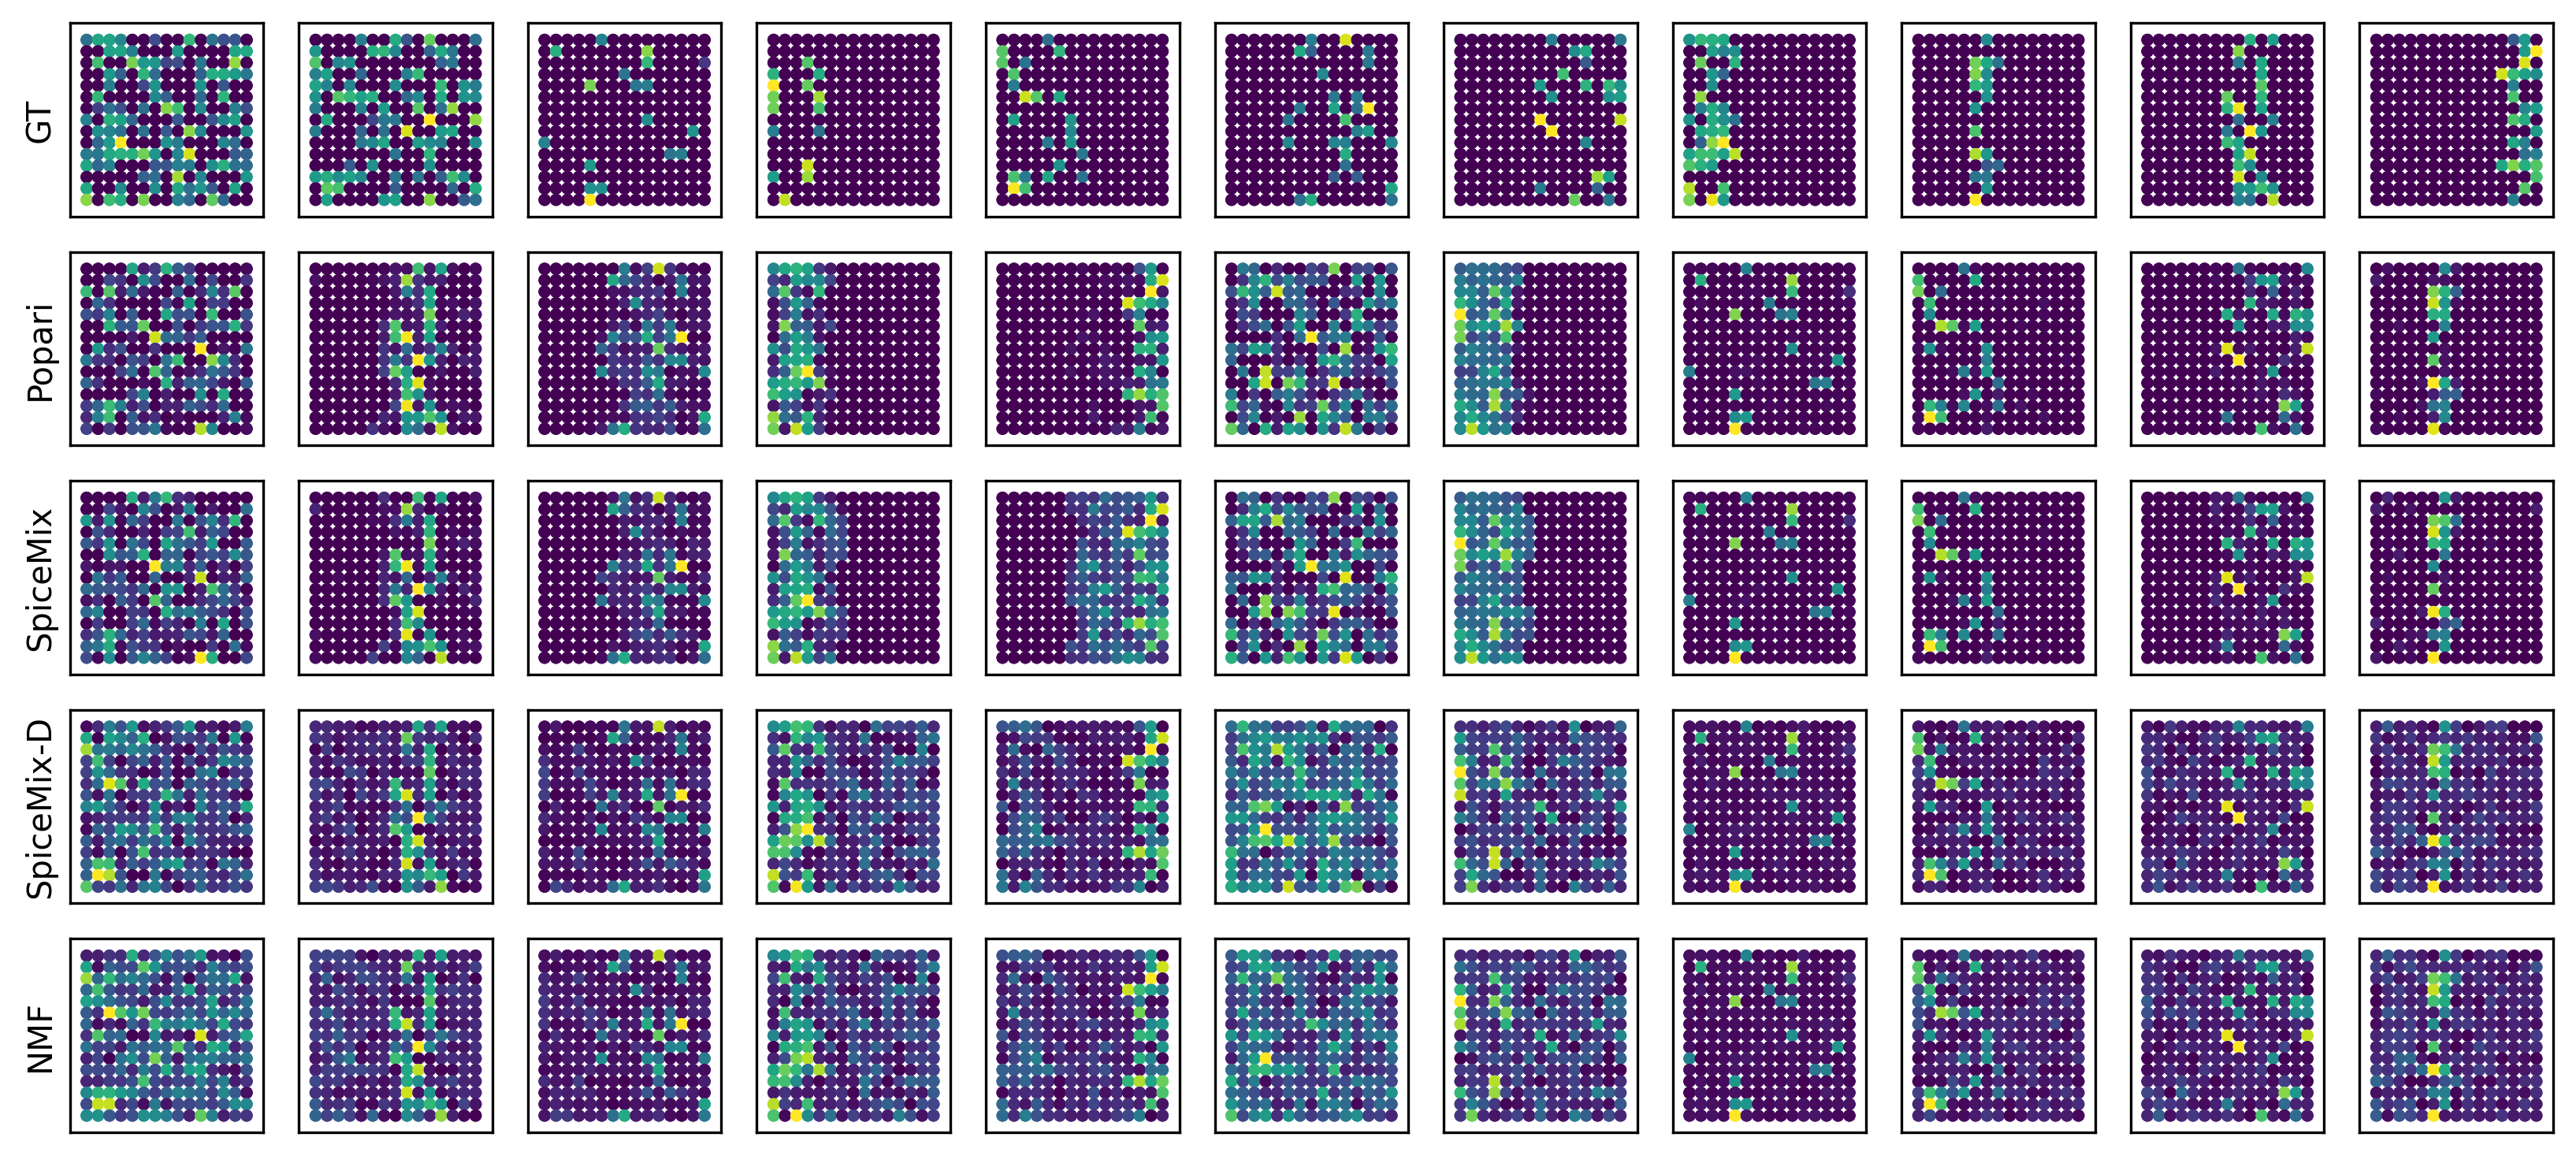

In [41]:
total_metagenes = 11
fov = 0
size= 25

fig, axes = plt.subplots(5, total_metagenes, sharex=True, sharey=True, tight_layout=True, dpi=300, figsize=(total_metagenes, 5))
_plot_all_embeddings(popari.hierarchy[0].datasets[fov], size=size, embedding_key="ground_truth_X", colorbar=False, fig=fig, ax=axes[0, :].flat, edgecolors='none')
_plot_all_embeddings(popari.hierarchy[0].datasets[fov], size=size, colorbar=False, fig=fig, ax=axes[1, :K].flat, edgecolors='none')
_plot_all_embeddings(spicemix.datasets[fov], size=size, colorbar=False, fig=fig, ax=axes[2, :K].flat, edgecolors='none')
_plot_all_embeddings(disjoint_spicemix.datasets[fov], size=size, colorbar=False, fig=fig, ax=axes[3, :K].flat, edgecolors='none')

_plot_all_embeddings(nmf.datasets[fov], size=size, colorbar=False, fig=fig, ax=axes[4, :K].flat, edgecolors='none')
for ax in axes.flat:
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title("")
    
axes[0, 0].set_ylabel("GT")
axes[1, 0].set_ylabel("Popari")
axes[2, 0].set_ylabel("SpiceMix")
axes[3, 0].set_ylabel("SpiceMix-D")
axes[4, 0].set_ylabel("NMF")

Text(0, 0.5, 'NMF')

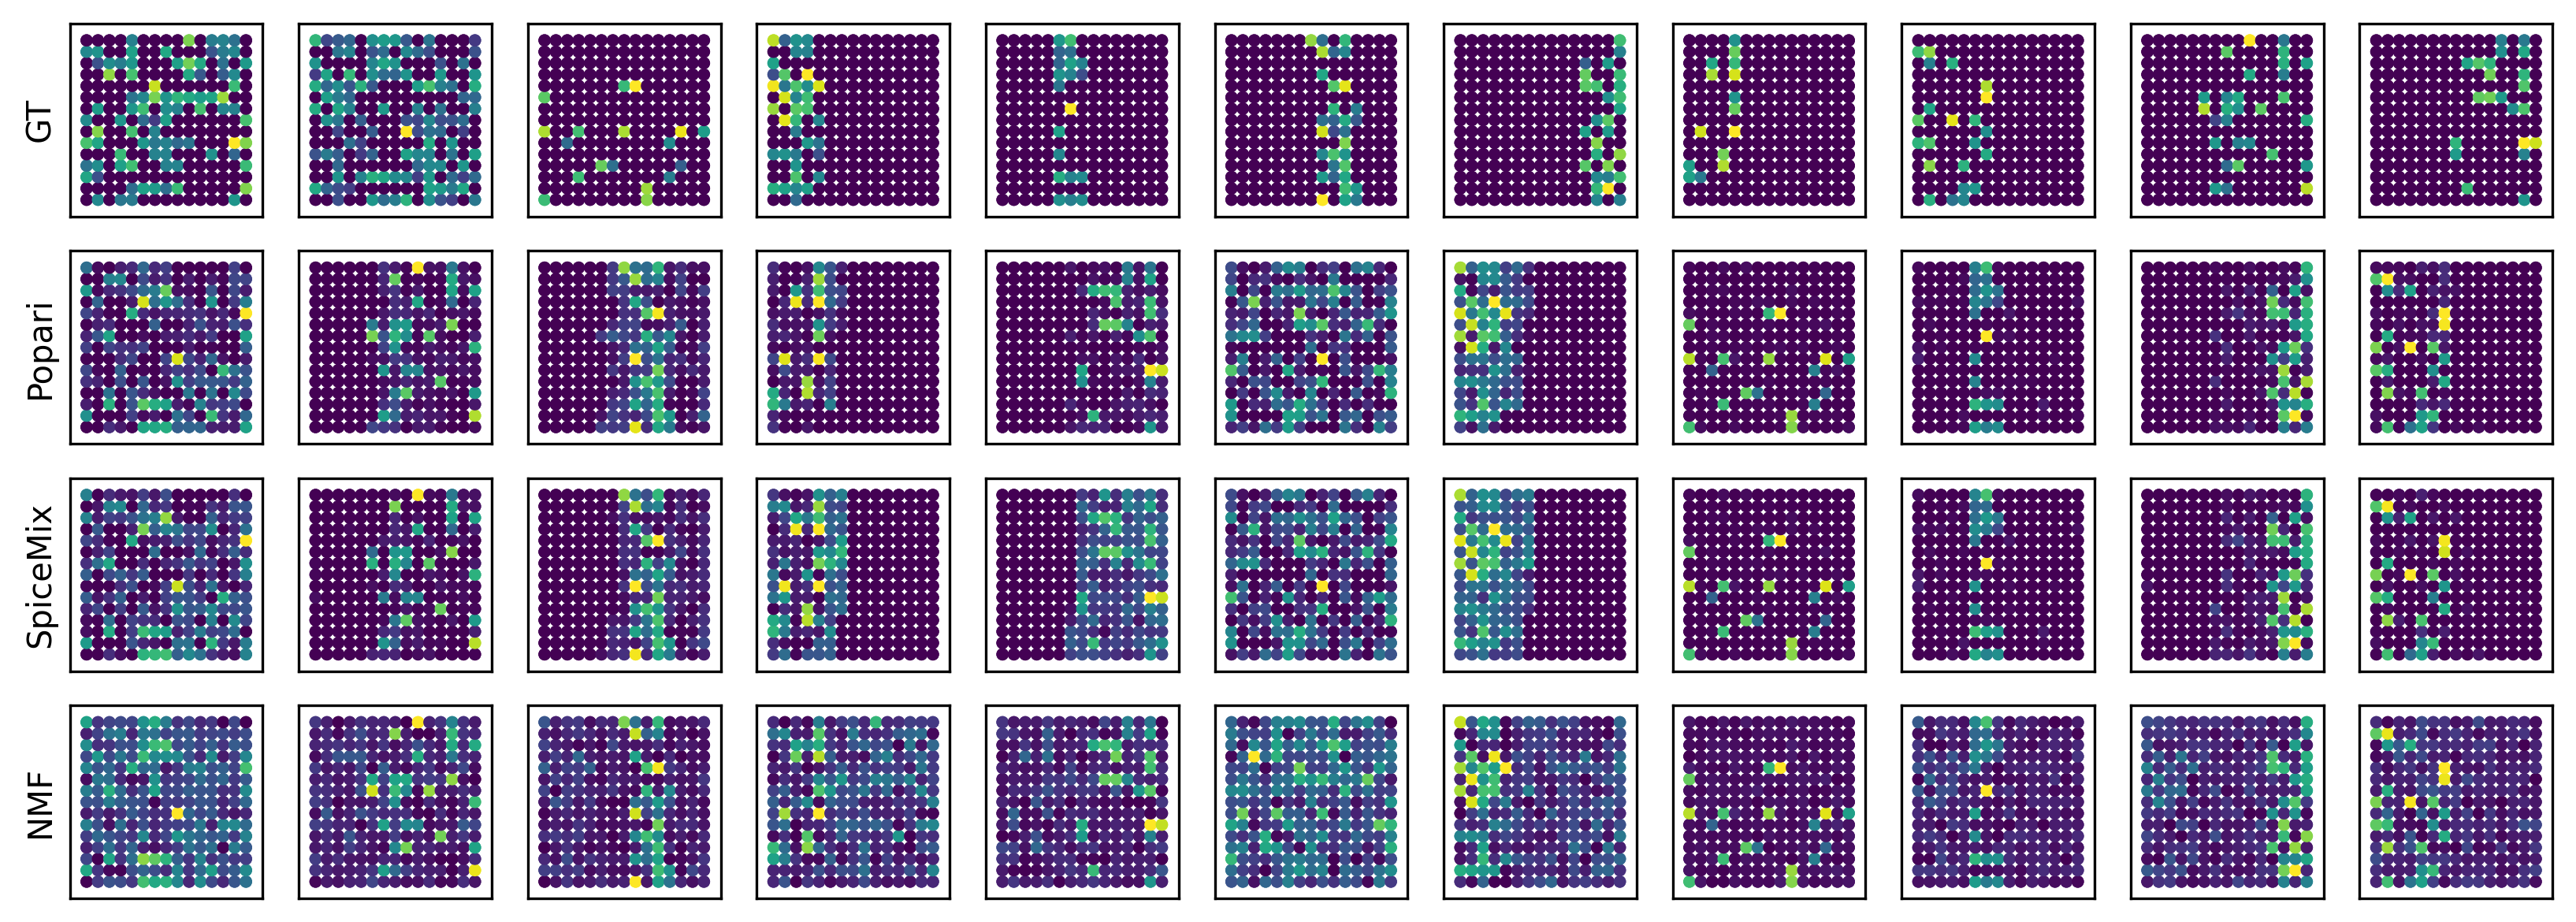

In [42]:
total_metagenes = 11
fov = 1
size= 25

fig, axes = plt.subplots(4, total_metagenes, sharex=True, sharey=True, tight_layout=True, dpi=300, figsize=(total_metagenes, 4))
_plot_all_embeddings(popari.hierarchy[0].datasets[fov], size=size, embedding_key="ground_truth_X", colorbar=False, fig=fig, ax=axes[0, :].flat, edgecolors='none')
_plot_all_embeddings(popari.hierarchy[0].datasets[fov], size=size, colorbar=False, fig=fig, ax=axes[1, :K].flat, edgecolors='none')
_plot_all_embeddings(spicemix.datasets[fov], size=size, colorbar=False, fig=fig, ax=axes[2, :K].flat, edgecolors='none')

_plot_all_embeddings(nmf.datasets[fov], size=size, colorbar=False, fig=fig, ax=axes[3, :K].flat, edgecolors='none')
for ax in axes.flat:
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title("")
    
axes[0, 0].set_ylabel("GT")
axes[1, 0].set_ylabel("Popari")
axes[2, 0].set_ylabel("SpiceMix")
axes[3, 0].set_ylabel("NMF")

## Generate random seeds

In [100]:
import itertools

root_path = Path("../../data/synthetic_cortex/joint_improvement_multireplicate_refactored/")

In [101]:
cell_type_definitions = {
    "Excitatory L1":         [0.5, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    "Excitatory L2":         [0.5, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    "Excitatory L3":         [0.5, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    "Excitatory L4":         [0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    "Inhibitory L1":         [0, 0.5, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    "Inhibitory L2":         [0, 0.5, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    "Inhibitory L3":         [0, 0.5, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    "Inhibitory L4":         [0, 0.5, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    "Non-Neuron Ubiquitous": [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
}
progenitor_distributions = {
    "L1": {
        "Excitatory L1": 0.53,
        "Inhibitory L1": 0.2,
        "Inhibitory L2": 0.2,
        "Non-Neuron Ubiquitous": 0.07,
    },
    "L2": {
        "Excitatory L2": 0.53,
        "Inhibitory L2": 0.2,
        "Inhibitory L3": 0.2,
        "Non-Neuron Ubiquitous": 0.07,
    },
    "L3": {
        "Excitatory L3": 0.53,
        "Inhibitory L3": 0.2,
        "Inhibitory L4": 0.2,
        "Non-Neuron Ubiquitous": 0.07,
    },
    "L4": {
        "Excitatory L4": 0.53,
        "Inhibitory L3": 0.2,
        "Inhibitory L4": 0.2,
        "Non-Neuron Ubiquitous": 0.07,
    },
}

layer_distributions = {
    "L1": {
        "Excitatory L1": 0.2,
        "Excitatory L2": 0.2,
        "Inhibitory L1": 0.53,
        "Non-Neuron Ubiquitous": 0.07,
    },
    "L2": {
        "Excitatory L2": 0.2,
        "Excitatory L3": 0.2,
        "Inhibitory L2": 0.53,
        "Non-Neuron Ubiquitous": 0.07,
    },
    "L3": {
        "Excitatory L3": 0.2,
        "Excitatory L4": 0.2,
        "Inhibitory L3": 0.53,
        "Non-Neuron Ubiquitous": 0.07,
    },
    "L4": {
        "Excitatory L3": 0.2,
        "Excitatory L4": 0.2,
        "Inhibitory L4": 0.53,
        "Non-Neuron Ubiquitous": 0.07,
    },
}

metagene_variation_probabilities = [0, 0.1, 0, 0, 0.1, 0.1, 0.1, 0, 0.1, 0.1, 0.1]

shared_parameters = {
    'num_genes': 100,
    'annotation_mode': 'domain',
    'num_real_metagenes': 11,
    'num_noise_metagenes': 0,
    'real_metagene_parameter': 8.0,
    'lambda_s': 1.,
    'width': 1,
    'height': 1,
    'grid_size': 15,
    'metagene_variation_probabilities': metagene_variation_probabilities,
    'cell_type_definitions': cell_type_definitions,
    'domain_key': 'domain',
}

In [ ]:
sigX_scale_options = np.linspace(1.0, 3.0, 5)
num_replicates_options = range(5, 6, 1)
sigY_scale_options = np.linspace(1.0, 3.0, 5)
noise_metagene_parameter_options = np.linspace(4.0, 4.0, 1)

options = itertools.product(sigX_scale_options, sigY_scale_options, noise_metagene_parameter_options, num_replicates_options, np.arange(20))
for sigX_scale, sigY_scale, noise_metagene_parameter, num_replicates, random_state in options:
    print(f"sigX_scale: {sigX_scale}\t"
          f"sigY_scale: {sigY_scale}\t"
          f"noise_metagene_parameter: {noise_metagene_parameter}\t"
          f"random_state: {random_state}\t"
          f"num_replicates: {num_replicates}\t"
    )

    progenitor_parameters = SimulationParameters(
        **shared_parameters,
        sig_x_scale=sigX_scale,
        sig_y_scale=sigY_scale,
        noise_metagene_parameter=noise_metagene_parameter,
        spatial_distributions=progenitor_distributions,
    )
    
    layer_parameters = SimulationParameters(
        **shared_parameters,
        spatial_distributions=layer_distributions,
    )
    
    duplicated_parameters = [
        {
            f"progenitor_{index}": progenitor_parameters,
            f"layer_{index}": layer_parameters,
        }
        for index in range(num_replicates)
    ]
            
    replicate_parameters = {replicate_name: parameters for replicate_parameters in duplicated_parameters for replicate_name, parameters in replicate_parameters.items()}
        
    run_path = root_path / f"num_replicates_{num_replicates}" / f"synthetic_{shared_parameters['grid_size']**2}_{shared_parameters['num_genes']}_sigY-scale-{sigY_scale}_sigX-scale-{sigX_scale}_noise-metagene-parameter_{noise_metagene_parameter}" / f"random_state_{random_state}"
    run_path.mkdir(exist_ok=True, parents=True)

    multireplicate_dataset = MultiReplicateSyntheticDataset(replicate_parameters, SyntheticDataset, random_state=random_state, verbose=1)
    
    for replicate in range(num_replicates):
        multireplicate_dataset.datasets[f"progenitor_{replicate}"].domain_canvas.load_domains(layer_domains)
        multireplicate_dataset.datasets[f"layer_{replicate}"].domain_canvas.load_domains(layer_domains)
    
    multireplicate_dataset.assign_domain_labels()
    multireplicate_dataset.simulate_expression()
    
    multireplicate_dataset.calculate_neighbors(coord_type="grid", n_neighs=4, delaunay=False)    
    
    (replicate_names, datasets) = zip(*multireplicate_dataset.datasets.items())
    
    # Sanity check plot
    replicate_names, dataset_copies = zip(*multireplicate_dataset.datasets.items())
    merged_dataset = ad.concat(dataset_copies, label="batch", keys=replicate_names, merge="unique", uns_merge="unique", pairwise=True)                                                                                                                                        
    
    sc.pp.neighbors(merged_dataset)
    sc.tl.umap(merged_dataset)
    
    fig, ax = plt.subplots()
    sc.pl.umap(merged_dataset, color="cell_type", ax=ax)
    
    fig, ax = plt.subplots()
    sc.pl.umap(merged_dataset, color="batch", ax=ax)
    
    
    save_anndata(run_path/ "processed_dataset.h5ad", datasets)
    
    print(run_path/ "processed_dataset.h5ad")